In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import integrate

In [2]:
from multi_loc import covariance, assimilate, utilities

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [5]:
importlib.reload(assimilate)
importlib.reload(utilities)

<module 'multi_loc.utilities' from '/home2/travis/python_code/multi_loc/multi_loc/utilities.py'>

In [9]:
K = 20
J = 15
F = 8
c = 10
b = 10
h = 1
N_ec = 20 # this is per fine ensemble
N_ef = 20

In [86]:
def L96_multi_ensemble(XY_ens, N_ec, F=8, c=10, b=10, h=1):
    """
    The ensemble XY_ens is size (J + N_ec + 1, K, N_ef).
    """
    shape = XY.shape
    J = shape[0] - N_ec - 1
    K = shape[1]
    N_ef = shape[2]
    x_ens_con = XY_ens[0:N_ec + 1]
    y_ens = XY_ens[N_ec + 1:]
    
    y_sum = y_ens.sum(axis=0)
    
    xp1 = np.roll(x, -1, axis=1)
    xm2 = np.roll(x, 2, axis=1)
    xm1 = np.roll(x, 1, axis=1)
    dxdt = (xp1 - xm2) * xm1 - x + F - (h * c) / b * y_sum[None, :, :]
    
    x_forcing =  np.repeat(x_ens_con[0], J)[:, None]
    y = y.reshape(J * K, N_ef)
    ym1 = np.roll(y, 1, axis=0)
    yp2 = np.roll(y, -2, axis=0)
    yp1 = np.roll(y, -1, axis=0)
    dydt = (c * b) * (ym1 - yp2) * yp1 - c*y + (h*c)/b*x_forcing
    
    dxydt = np.concatenate([dxdt, dydt.reshape(J, K, N_ef)],
                           axis=0)
    return dxydt

In [11]:
def L96_multi(XY, F=8, c=10, b=10, h=1):
    K = XY.shape[1]
    J = XY.shape[0] - 1
    x = XY[0, :]
    y = XY[1:, :]
    y_sum = y.sum(axis=0)
    
    xp1 = np.roll(x, -1, axis=0)
    xm2 = np.roll(x, 2, axis=0)
    xm1 = np.roll(x, 1, axis=0)
    dxdt = (xp1 - xm2) * xm1 - x + F - (h * c) / b * y_sum
    
    x_forcing =  np.repeat(x, J)
    y = y.ravel()
    ym1 = np.roll(y, 1, axis=0)
    yp2 = np.roll(y, -2, axis=0)
    yp1 = np.roll(y, -1, axis=0)
    dydt = (c * b)*(ym1 - yp2) * yp1 - c*y + (h*c)/b*x_forcing
    
    dxydt = np.concatenate([dxdt[None, :], dydt.reshape(J, K)],
                           axis=0)
    return dxydt

In [12]:
def return_L96_multi_data(XY0, t, F=8, b=10, c=10, h=1):
    K = XY0.shape[1]
    J = XY0.shape[0] - 1
    def this_L96_multi(XY_1D, t):
        XY = XY_1D.reshape(J + 1, K)
        dXYdt = L96_multi(XY, F=F, b=b, c=c, h=h)
        return dXYdt.ravel()
    XY = integrate.odeint(this_L96_multi, XY0.ravel(), t)
    return XY

In [13]:
X0 = np.random.uniform(low=-5, high=10, size=K)

In [14]:
Y0 = np.random.uniform(low=-0.5, high=1, size=(J * K)).reshape(J, K)

In [15]:
XY0 = np.concatenate([[X0], Y0], axis=0)

In [16]:
t = [0, 100]

In [17]:
XY_1D0 = return_L96_multi_data(XY0, t, F=F, b=b, c=c, h=h)

/home/travis/miniconda3/envs/loc/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [18]:
XY_init = XY_1D0.reshape(XY_1D0.shape[0], J + 1, K)

In [19]:
theta_K = np.linspace(0, 2 * np.pi, K + 1) + np.pi / K
theta_JK = np.linspace(0, 2 * np.pi, K * J + 1)

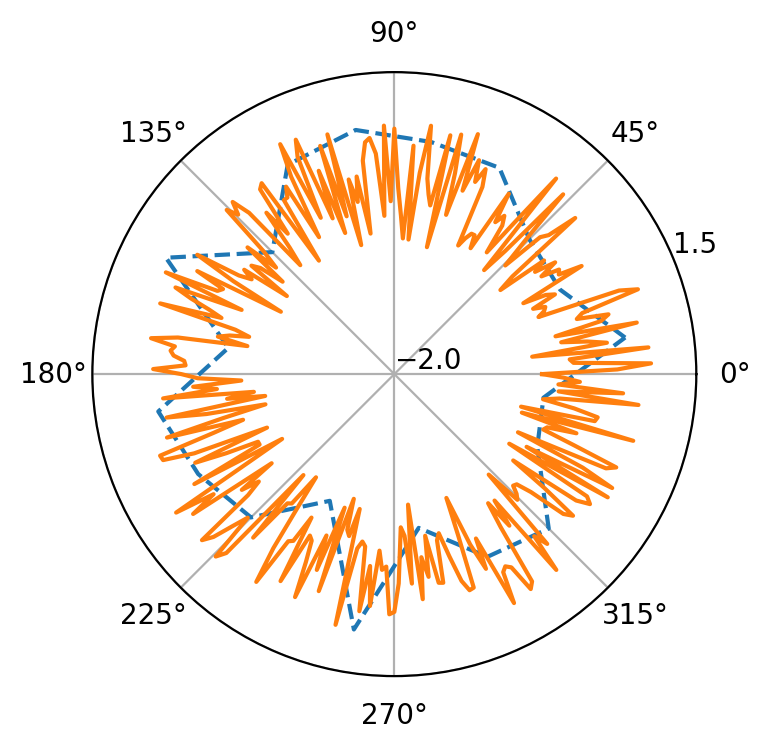

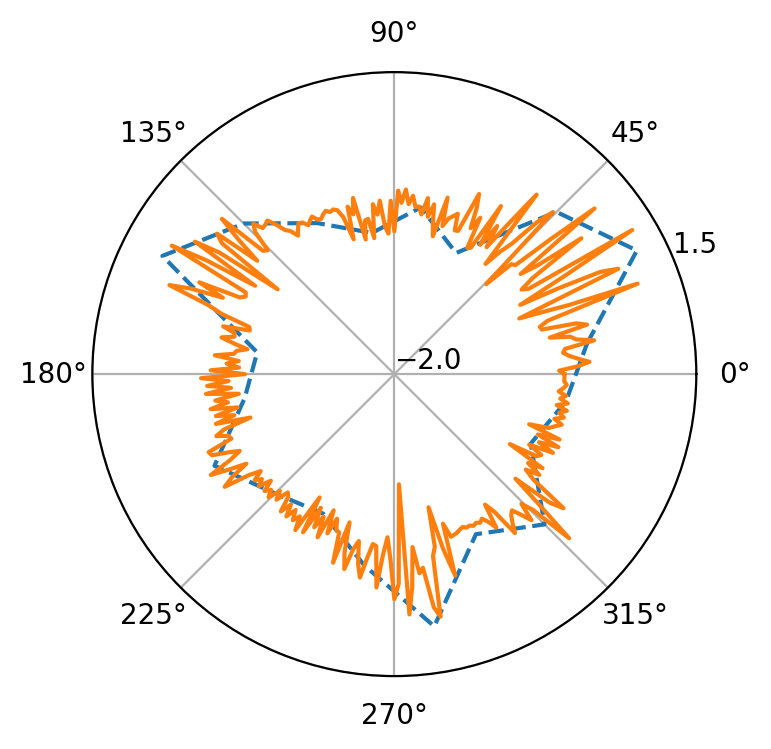

In [20]:
X_to_plot = 0.1 *XY_init[0, 0, :]
X_to_plot = np.concatenate([X_to_plot,
                            [X_to_plot[0]]])
Y_to_plot = XY_init[0, 1:, :].ravel()
Y_to_plot = np.concatenate([Y_to_plot, 
                            [Y_to_plot[0]]])

plt.figure(dpi=200)
plt.polar(theta_K, X_to_plot, '--')
plt.polar(theta_JK, Y_to_plot)
plt.yticks([-2, 1.5])
plt.show()

X_to_plot = 0.1 *XY_init[1, 0, :]
X_to_plot = np.concatenate([X_to_plot,
                            [X_to_plot[0]]])
Y_to_plot = XY_init[1, 1:, :].ravel()
Y_to_plot = np.concatenate([Y_to_plot, 
                            [Y_to_plot[0]]])

plt.figure(dpi=200)
plt.polar(theta_K, X_to_plot, '--')
plt.polar(theta_JK, Y_to_plot)
plt.yticks([-2, 1.5])
plt.show()

In [21]:
XY0 = XY_init[1]

In [25]:
N

20001

In [69]:
T = 1000
dt = 0.05
N = int(T/dt + 1)
t = np.linspace(0, T, N)

In [70]:
XY_1D = return_L96_multi_data(XY0, t, F=F, b=b, c=c, h=h)

In [71]:
XY = XY_1D.reshape(XY_1D.shape[0], J + 1, K)

In [72]:
theta_K = np.linspace(0, 2 * np.pi, K + 1) + np.pi / K
theta_JK = np.linspace(0, 2 * np.pi, K * J + 1)

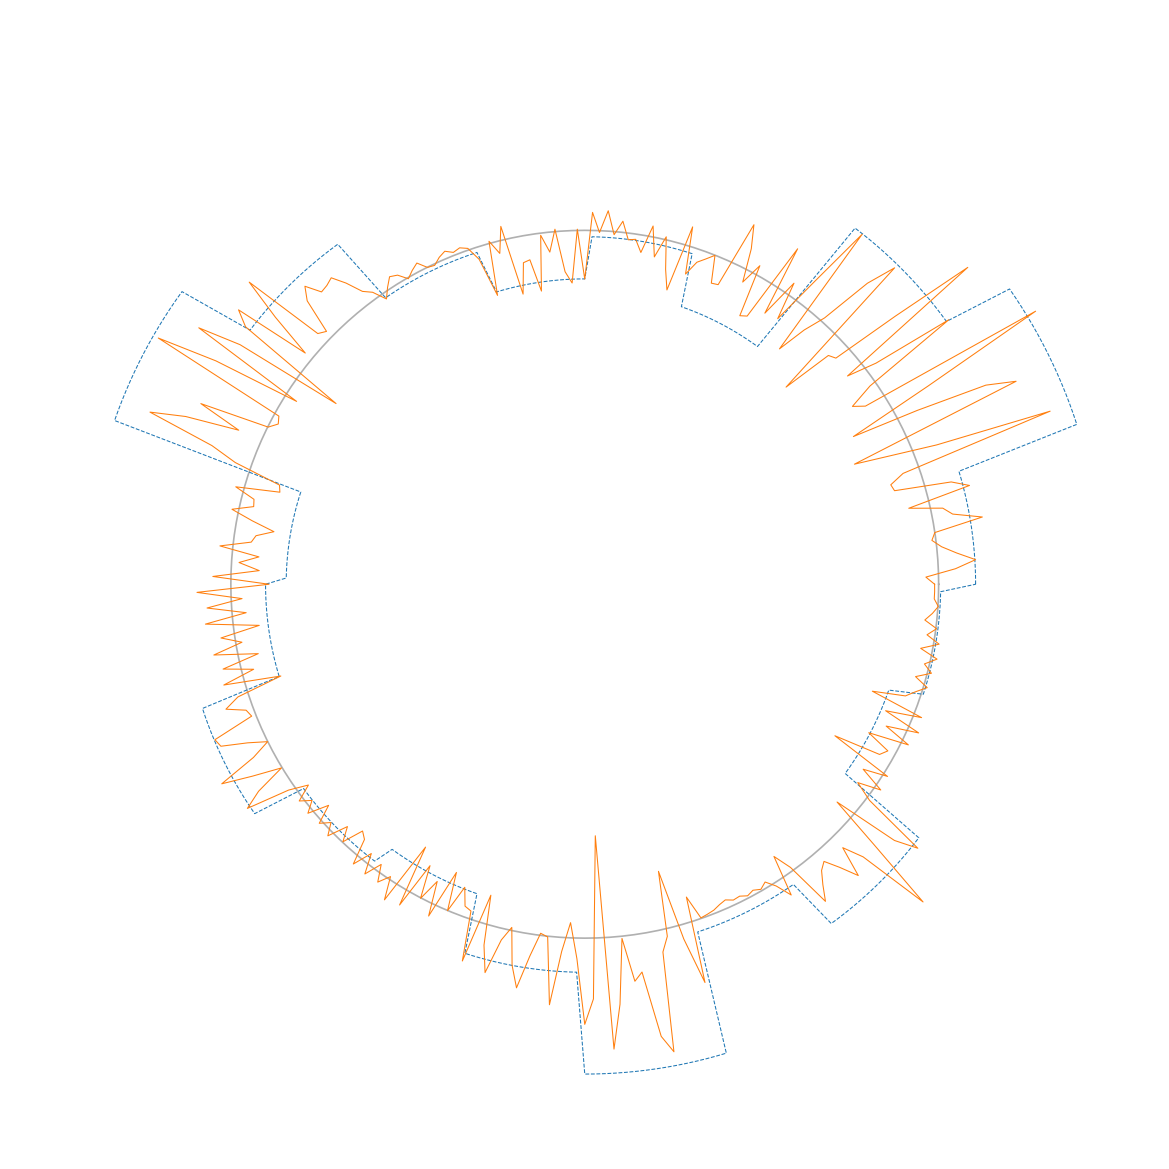

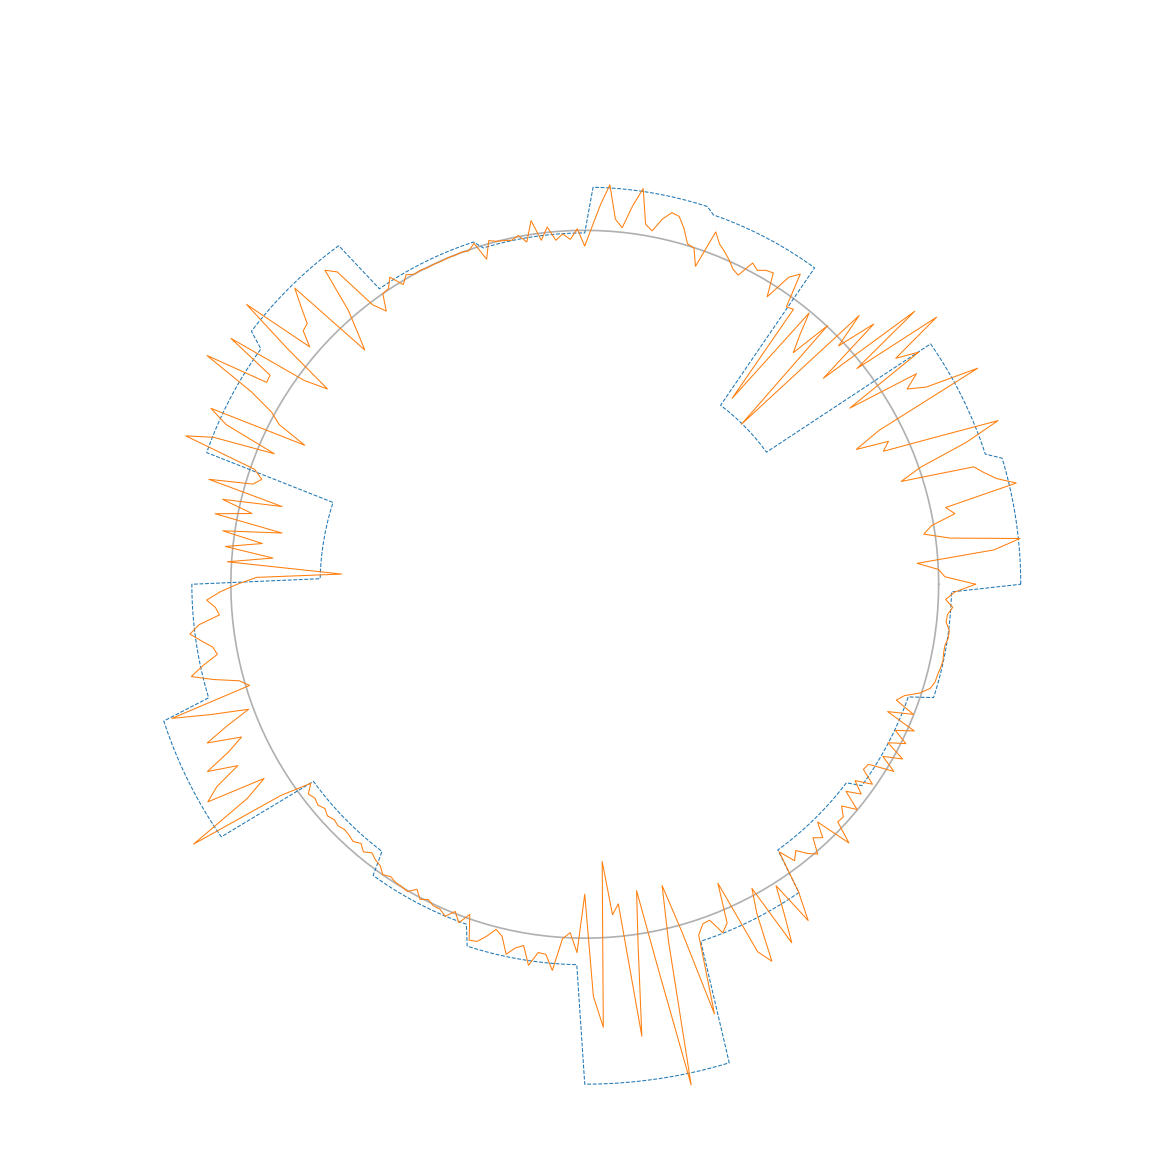

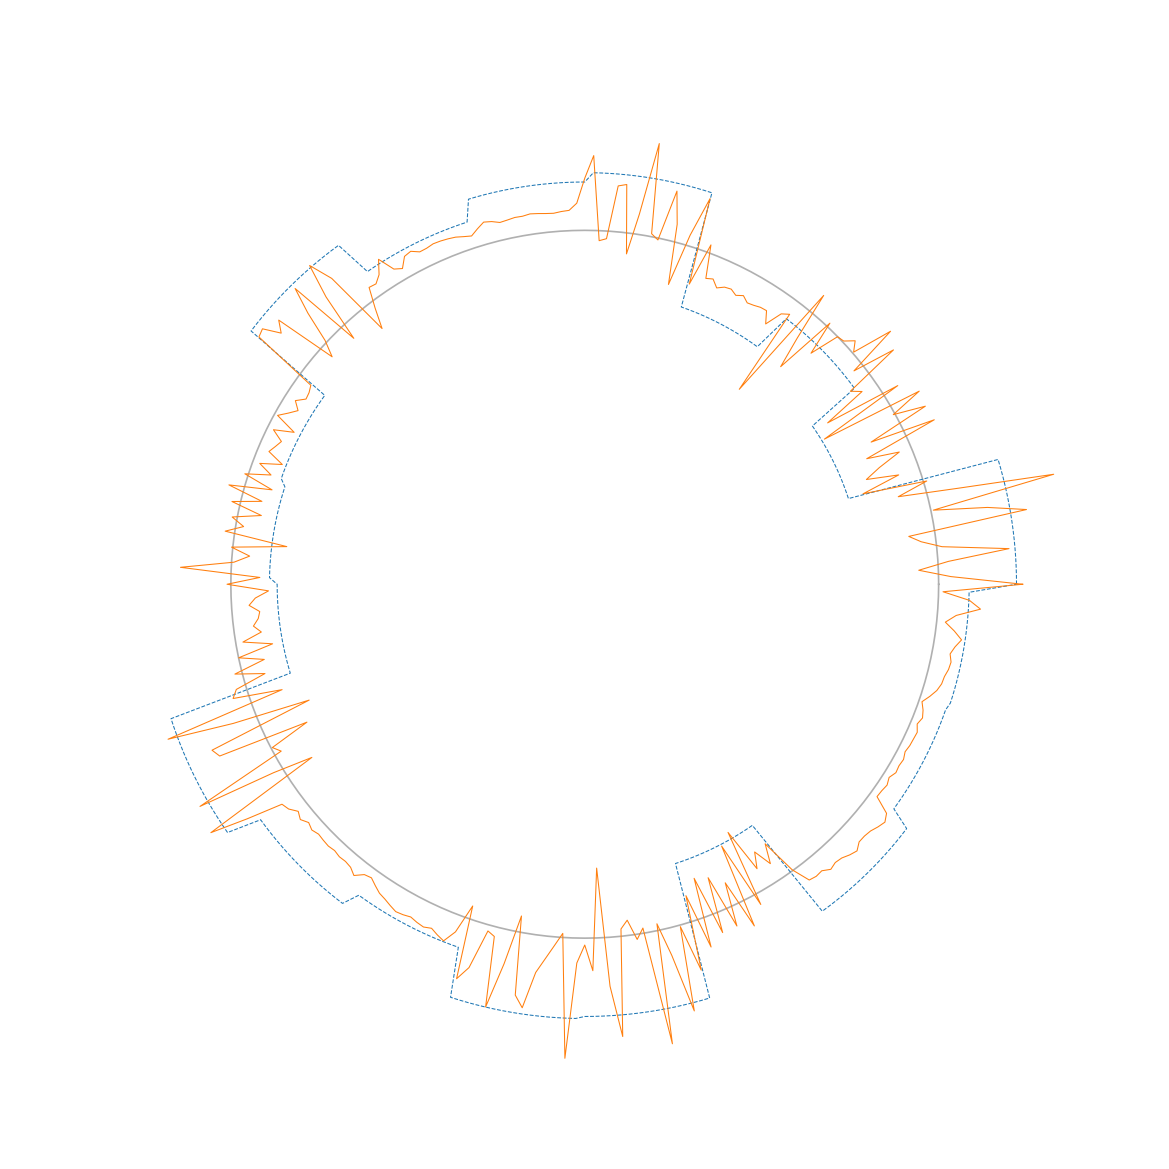

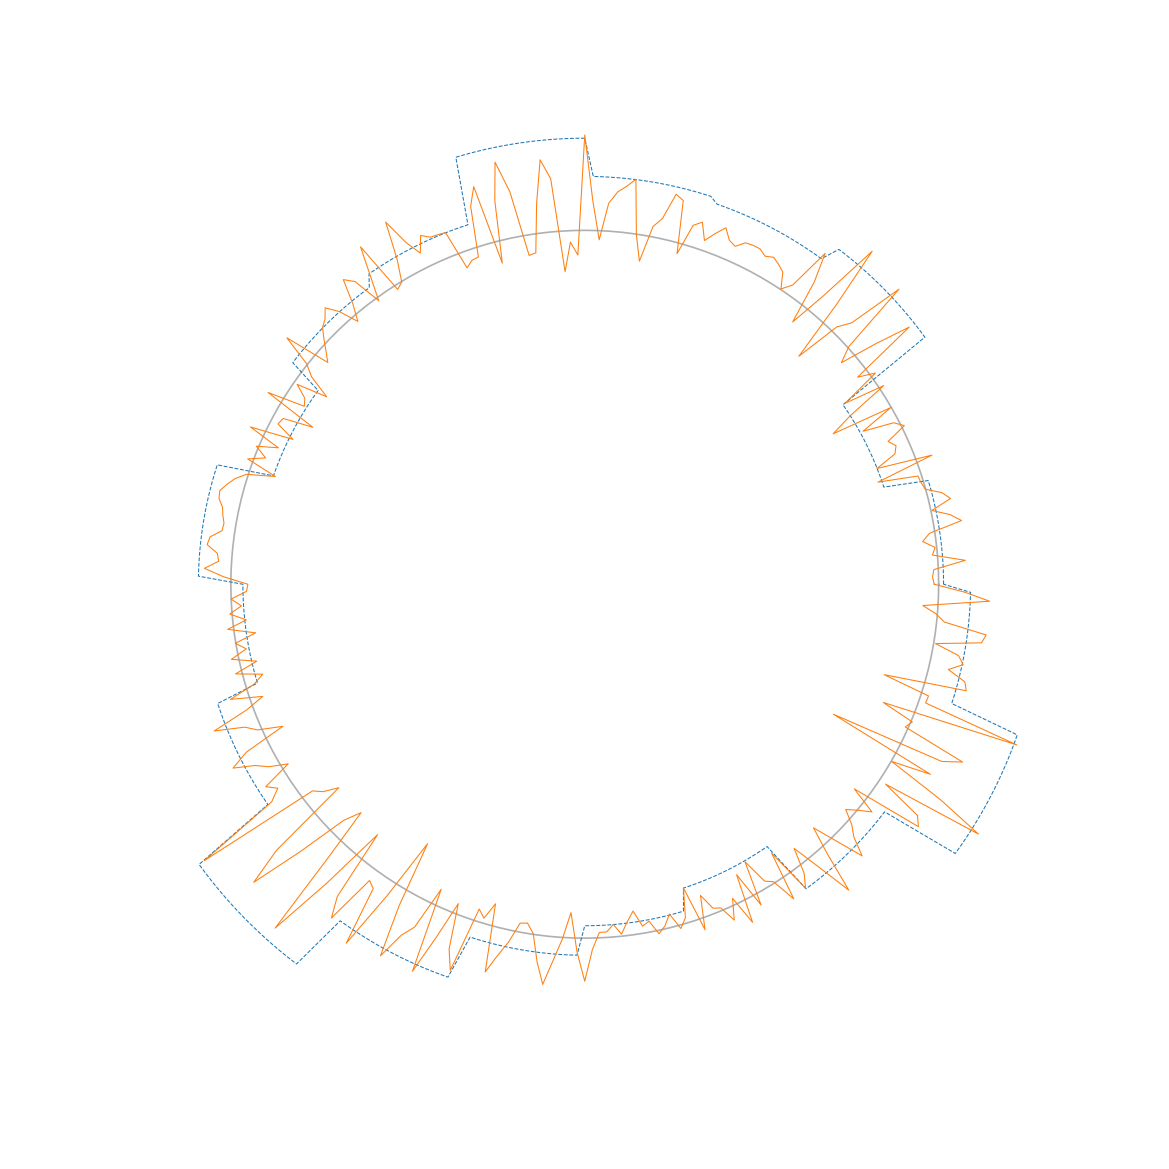

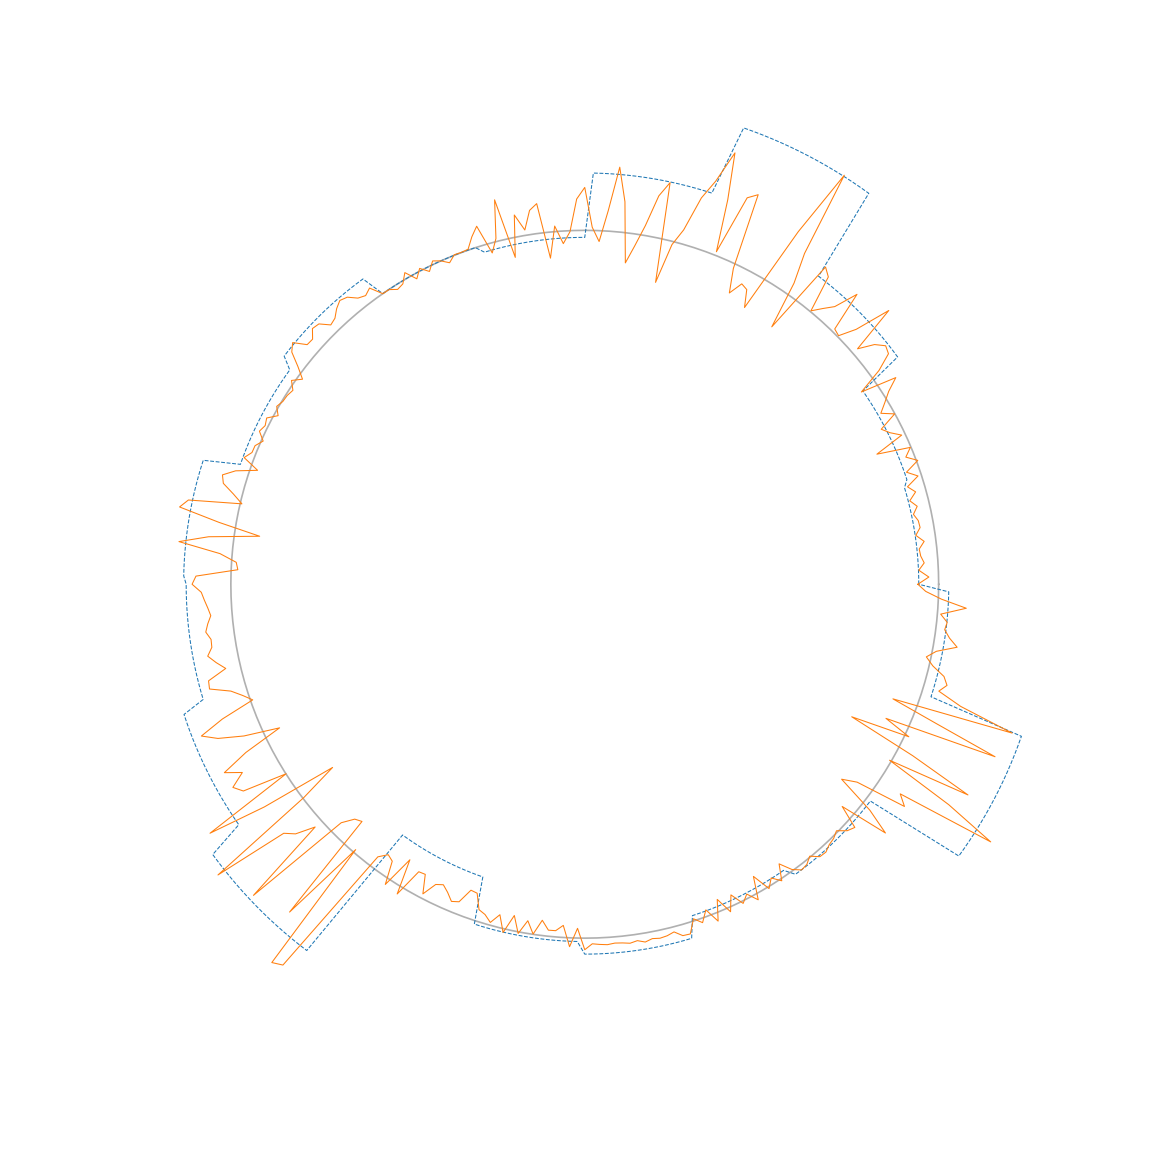

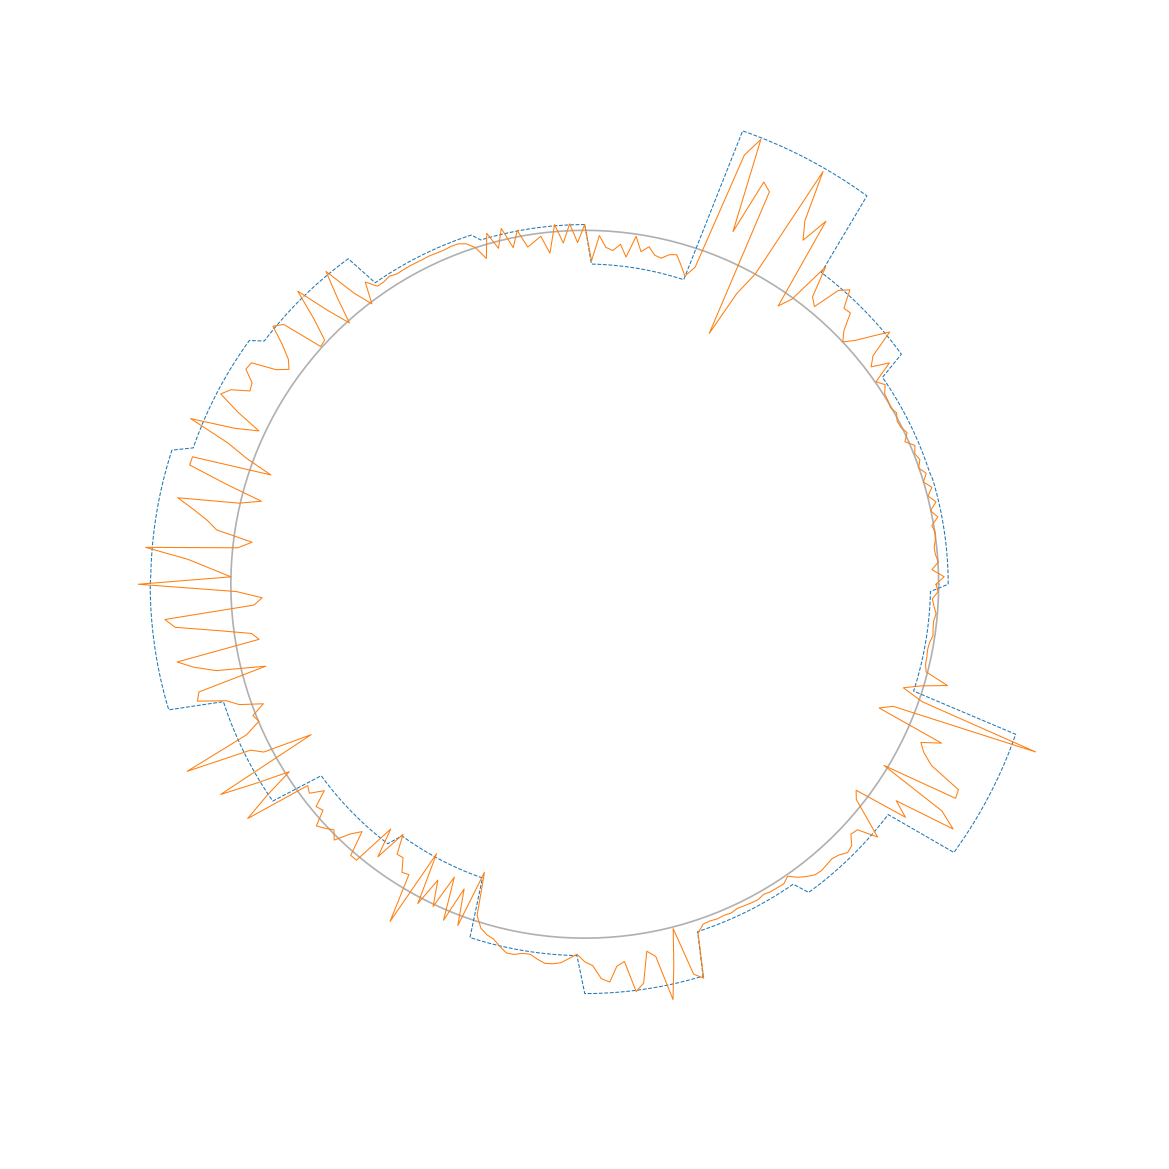

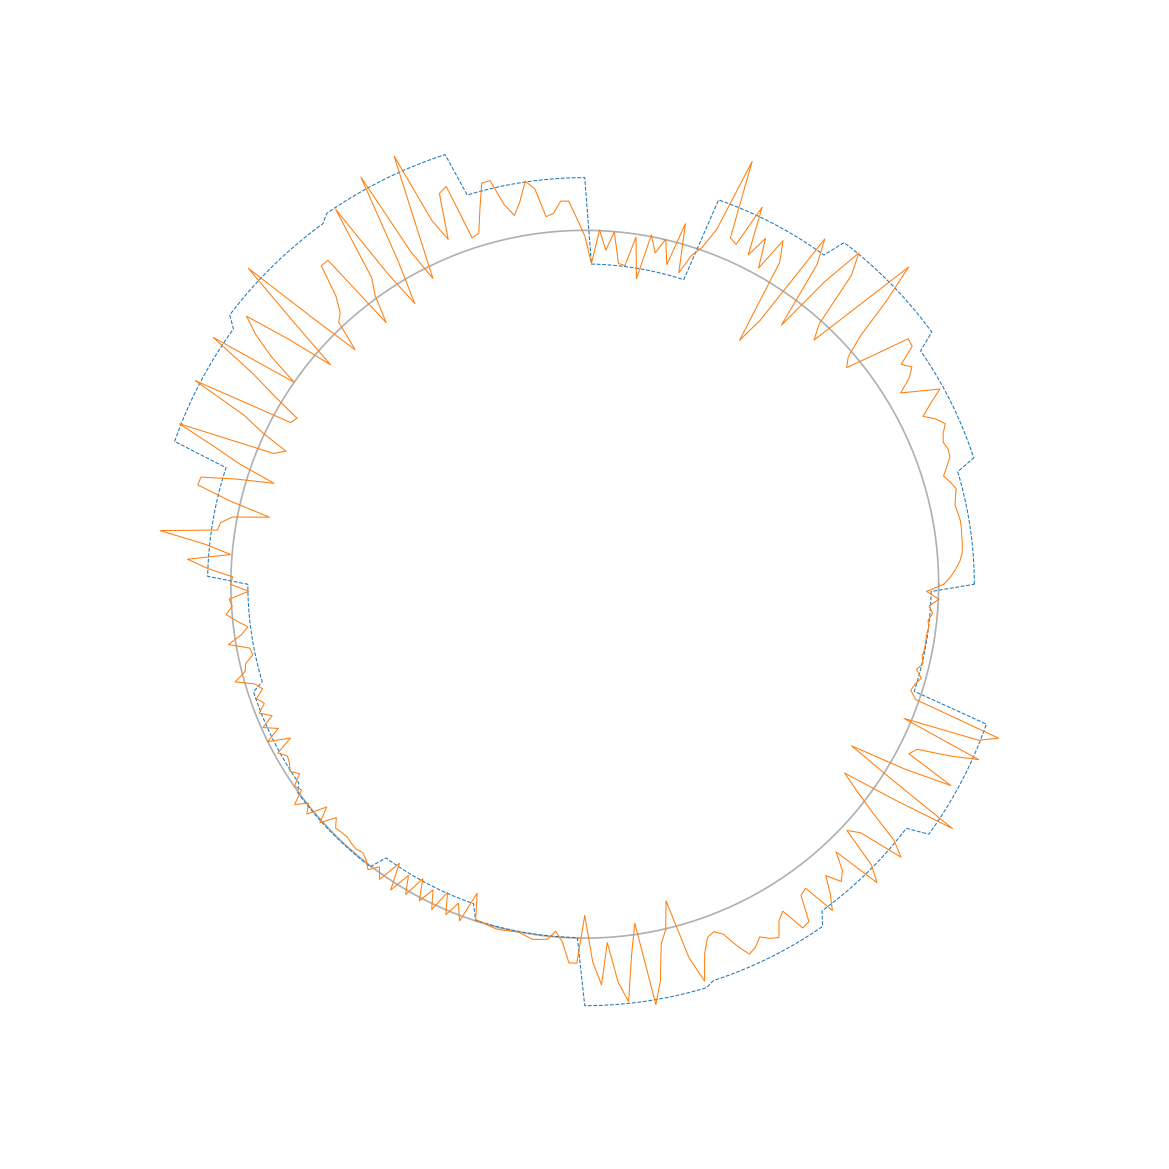

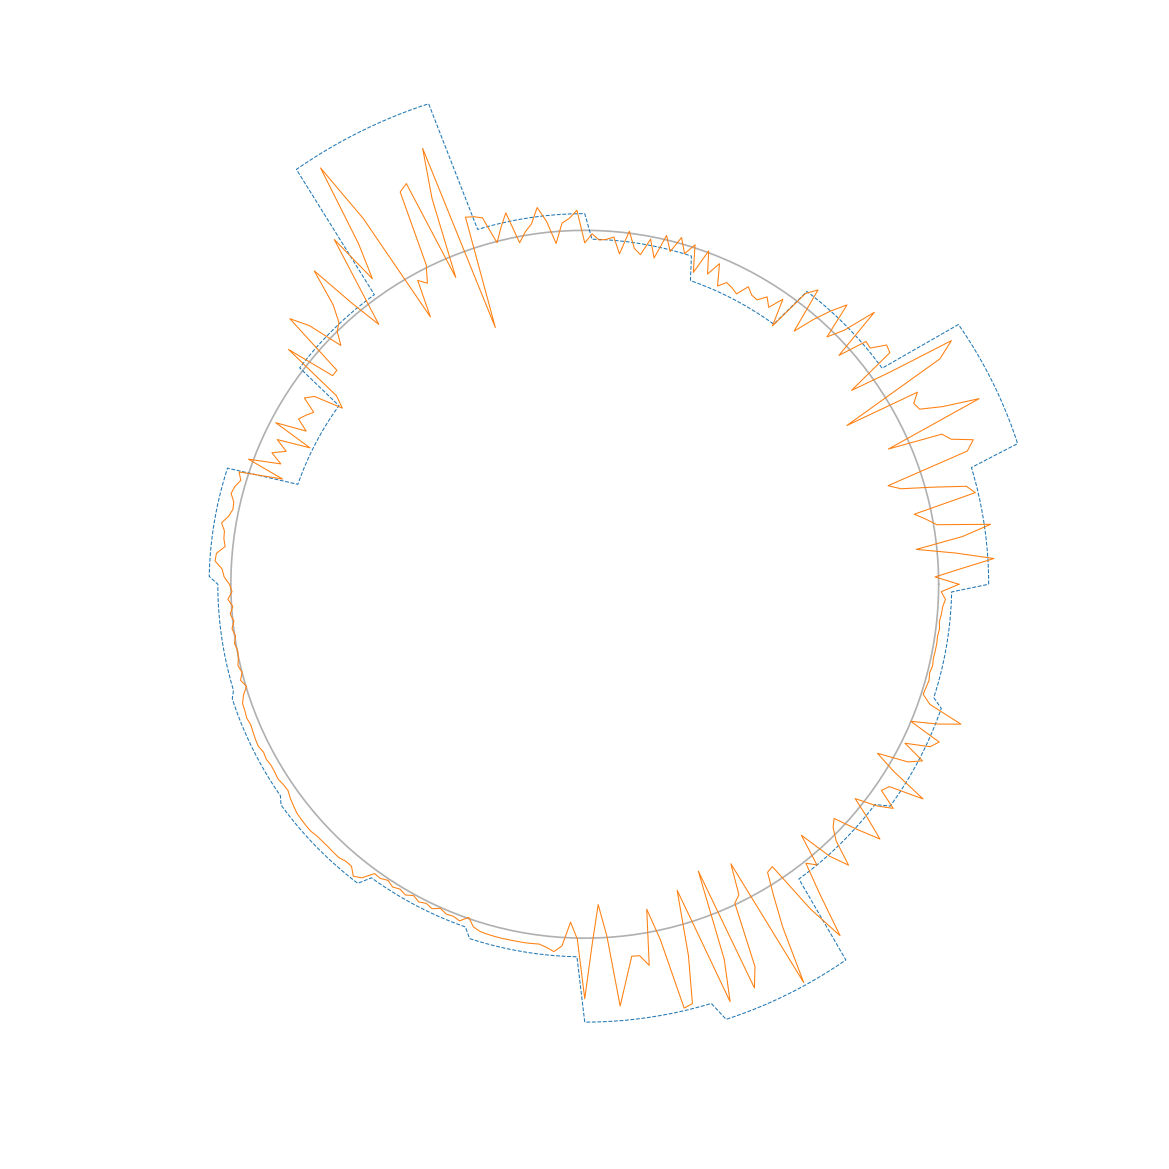

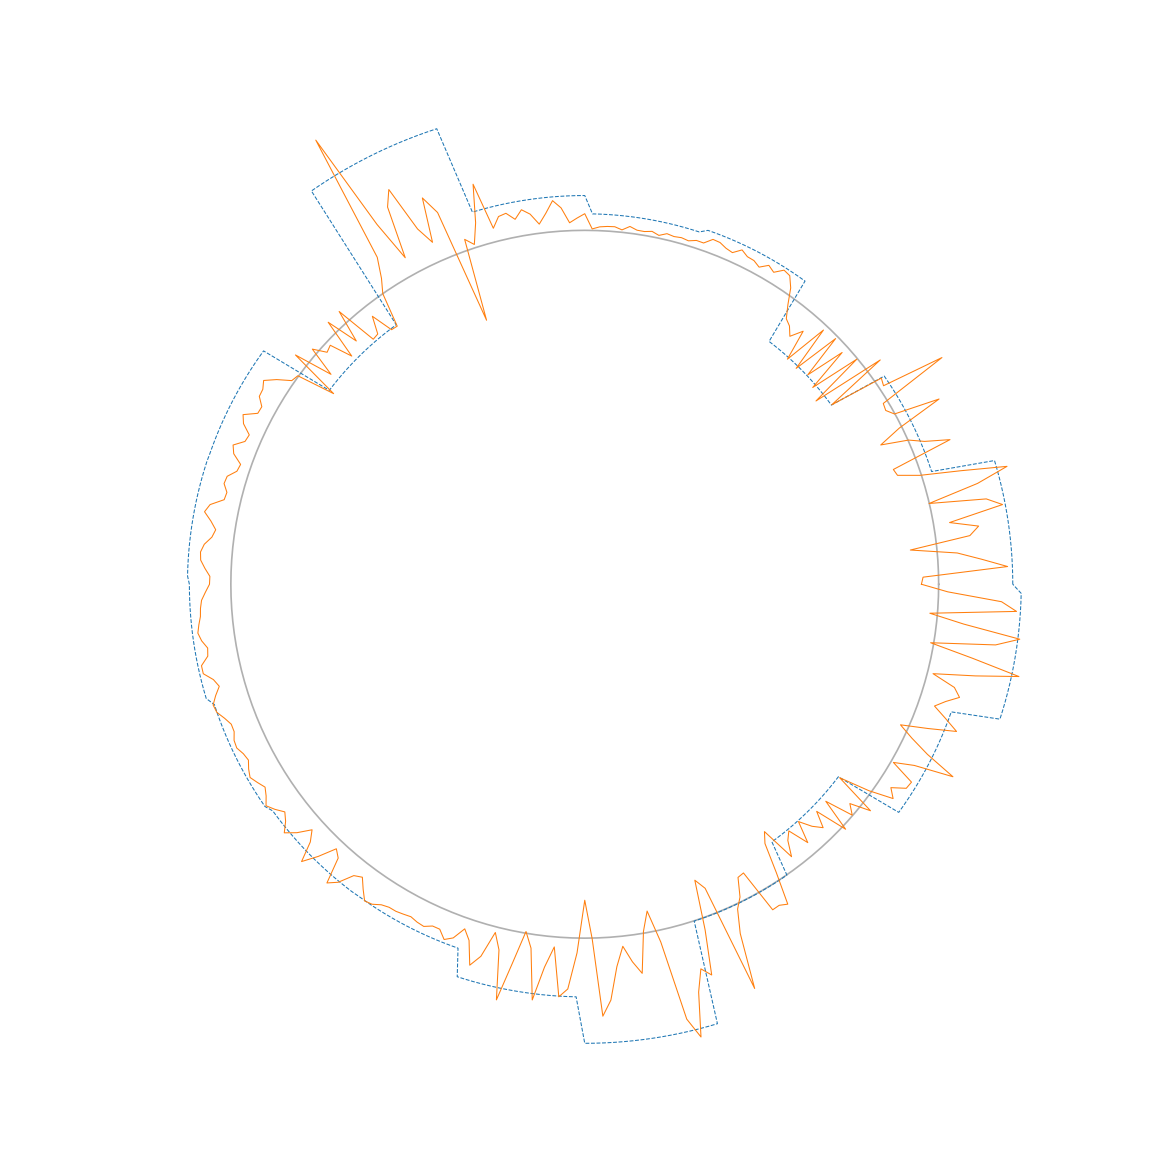

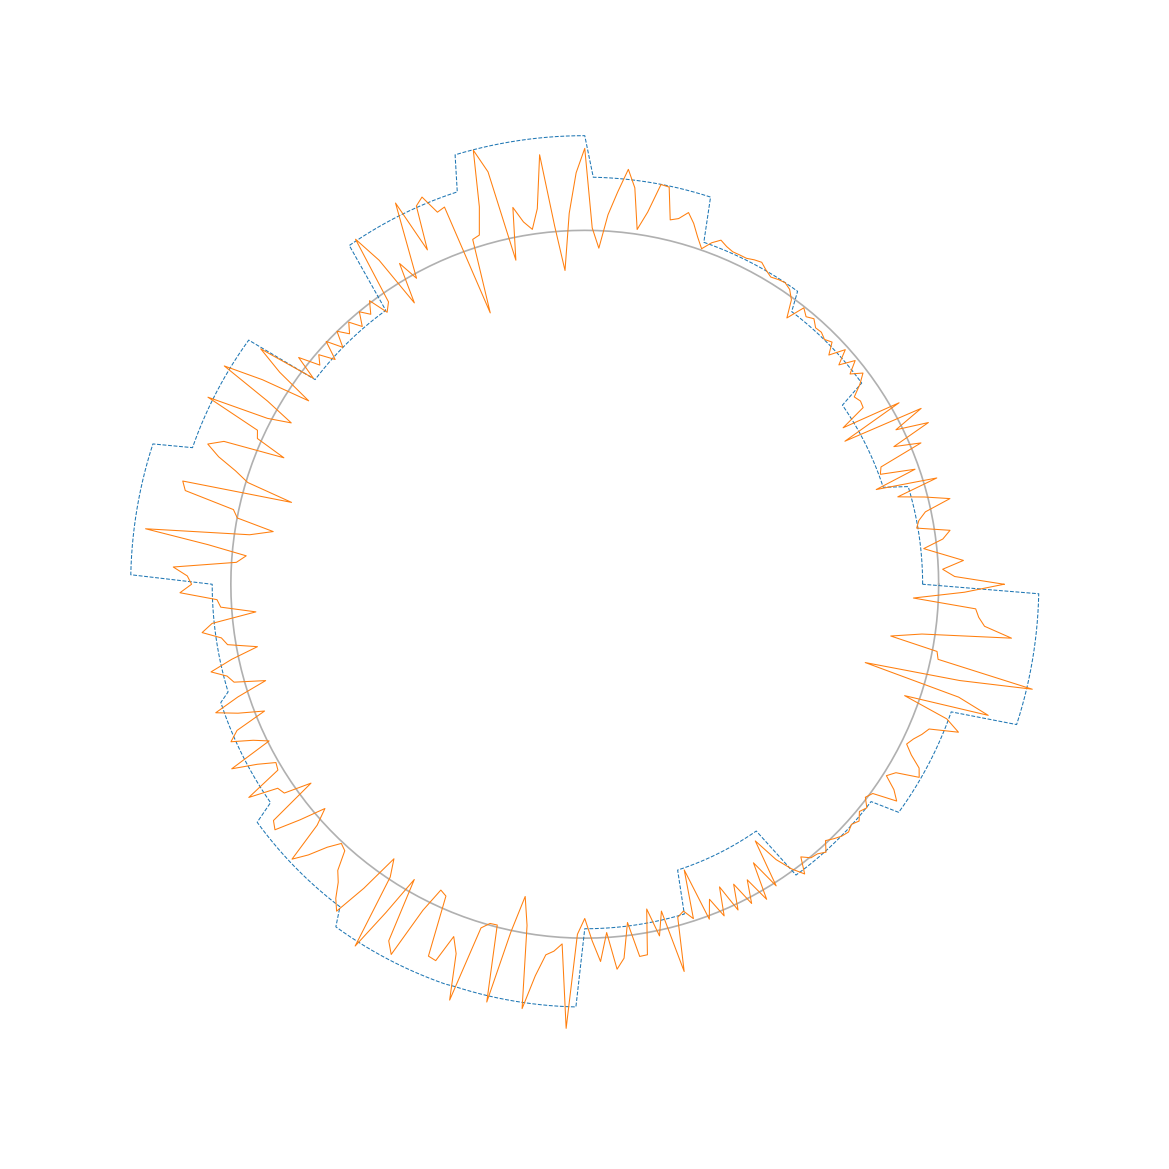

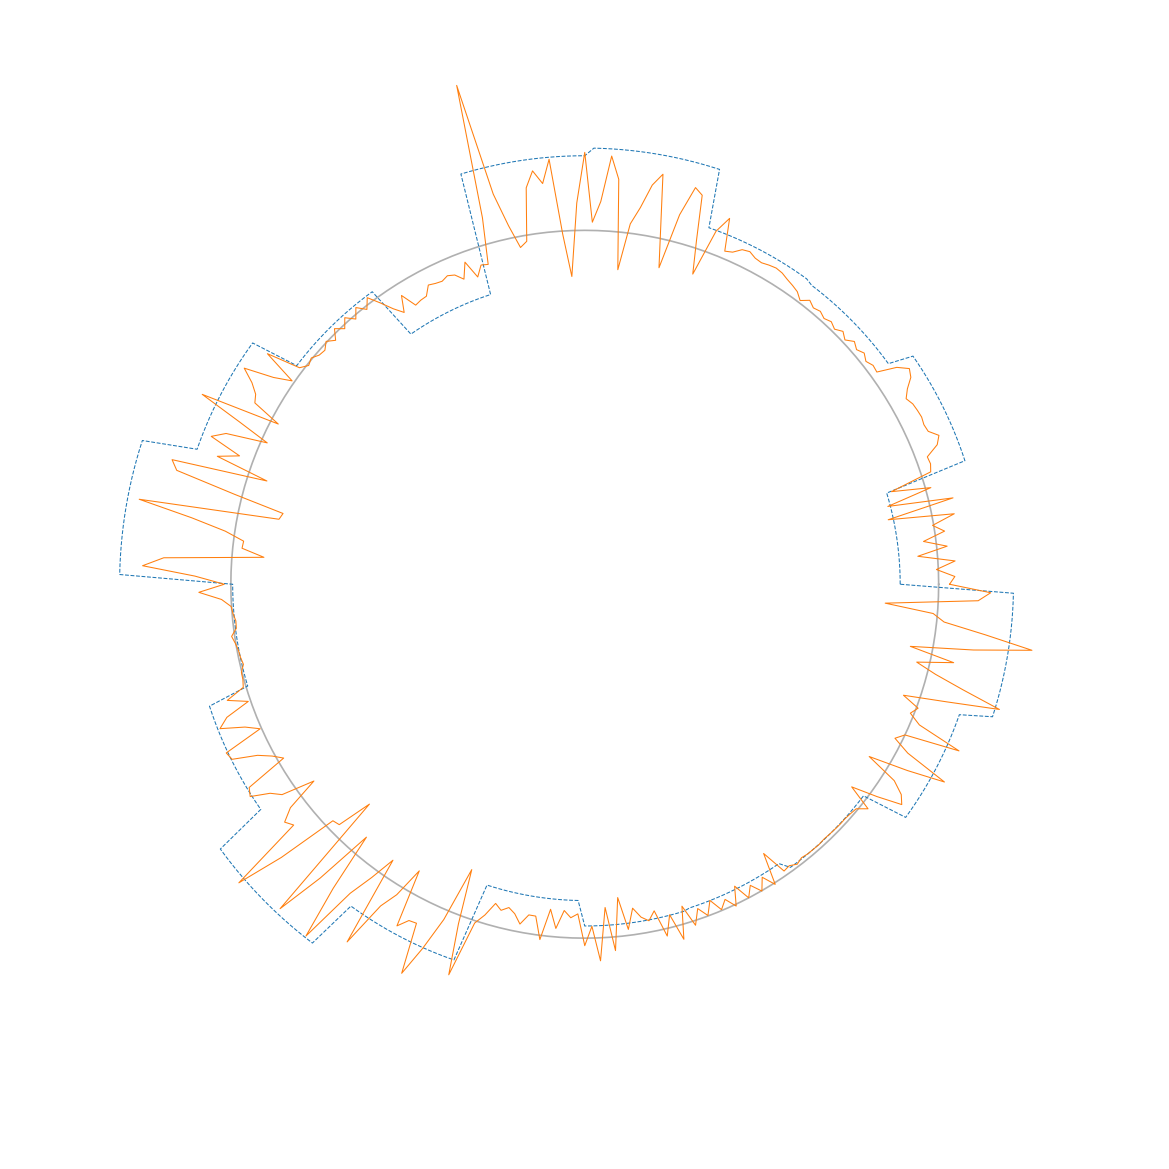

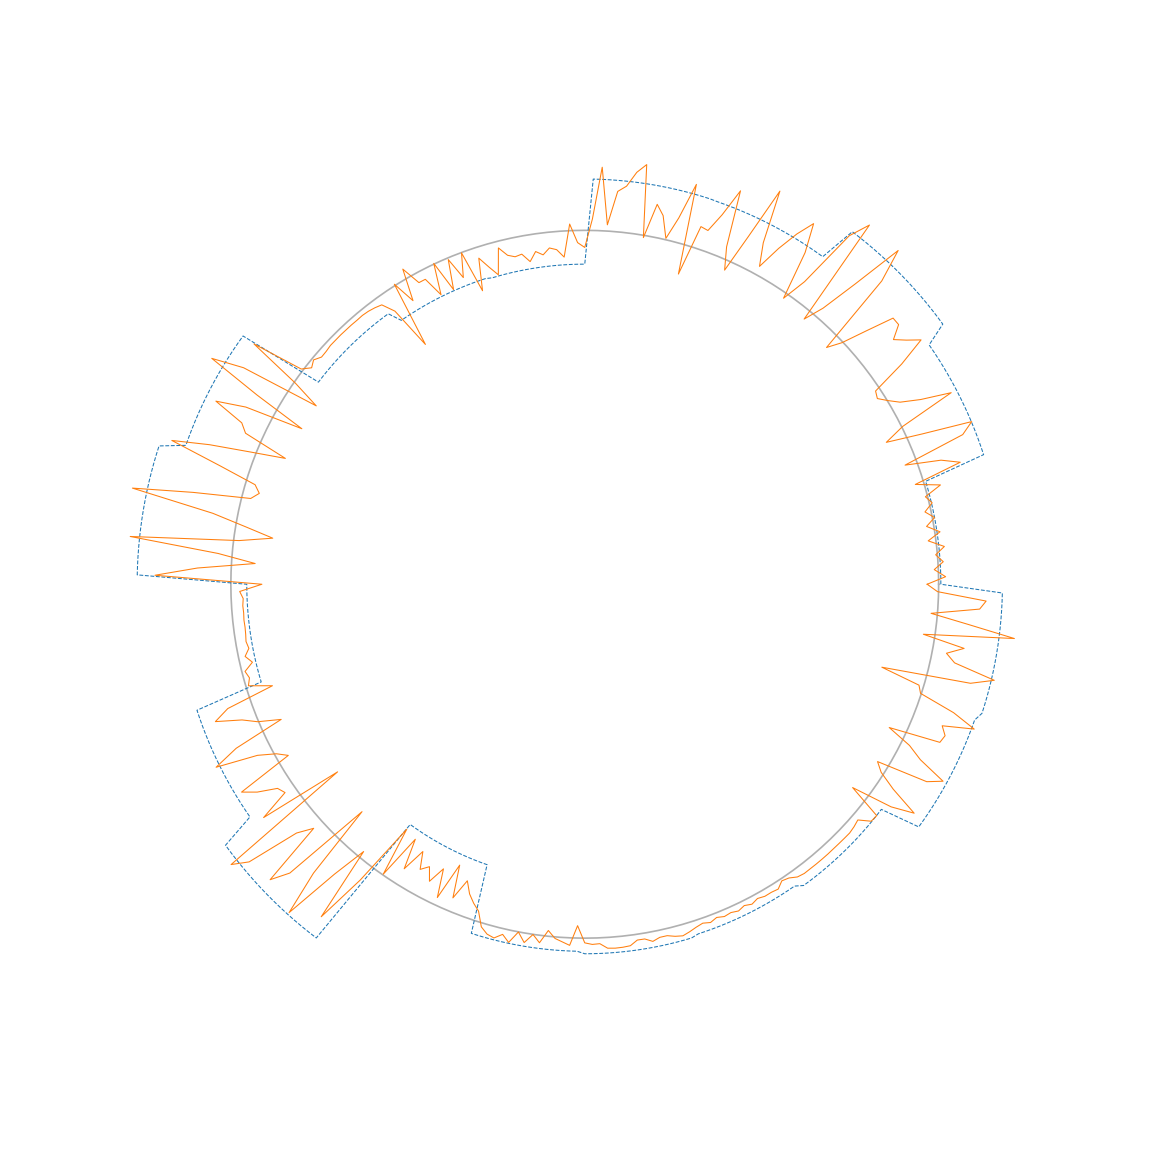

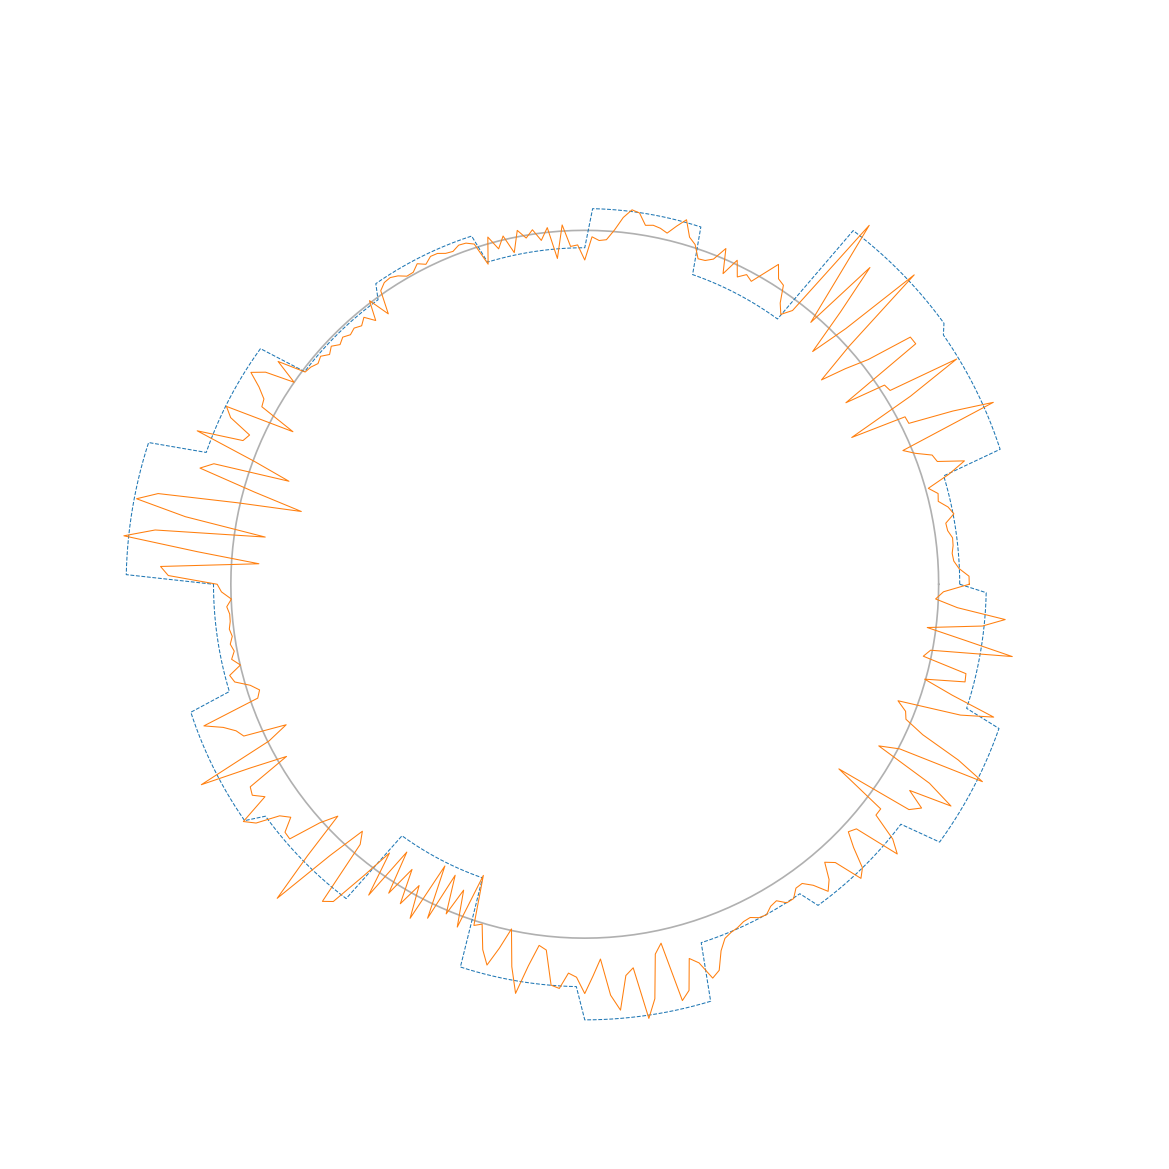

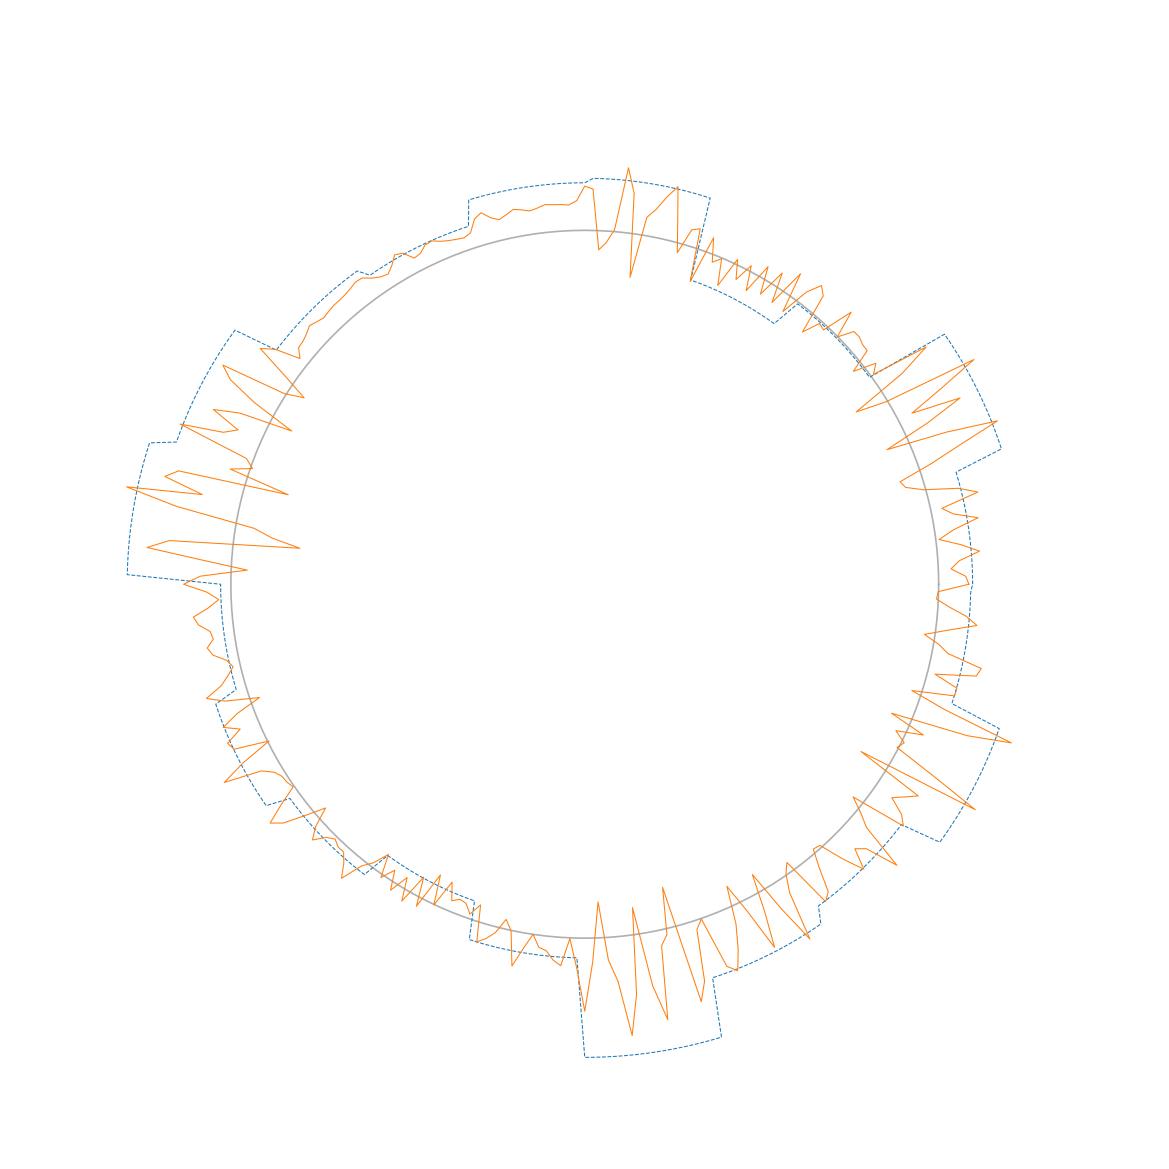

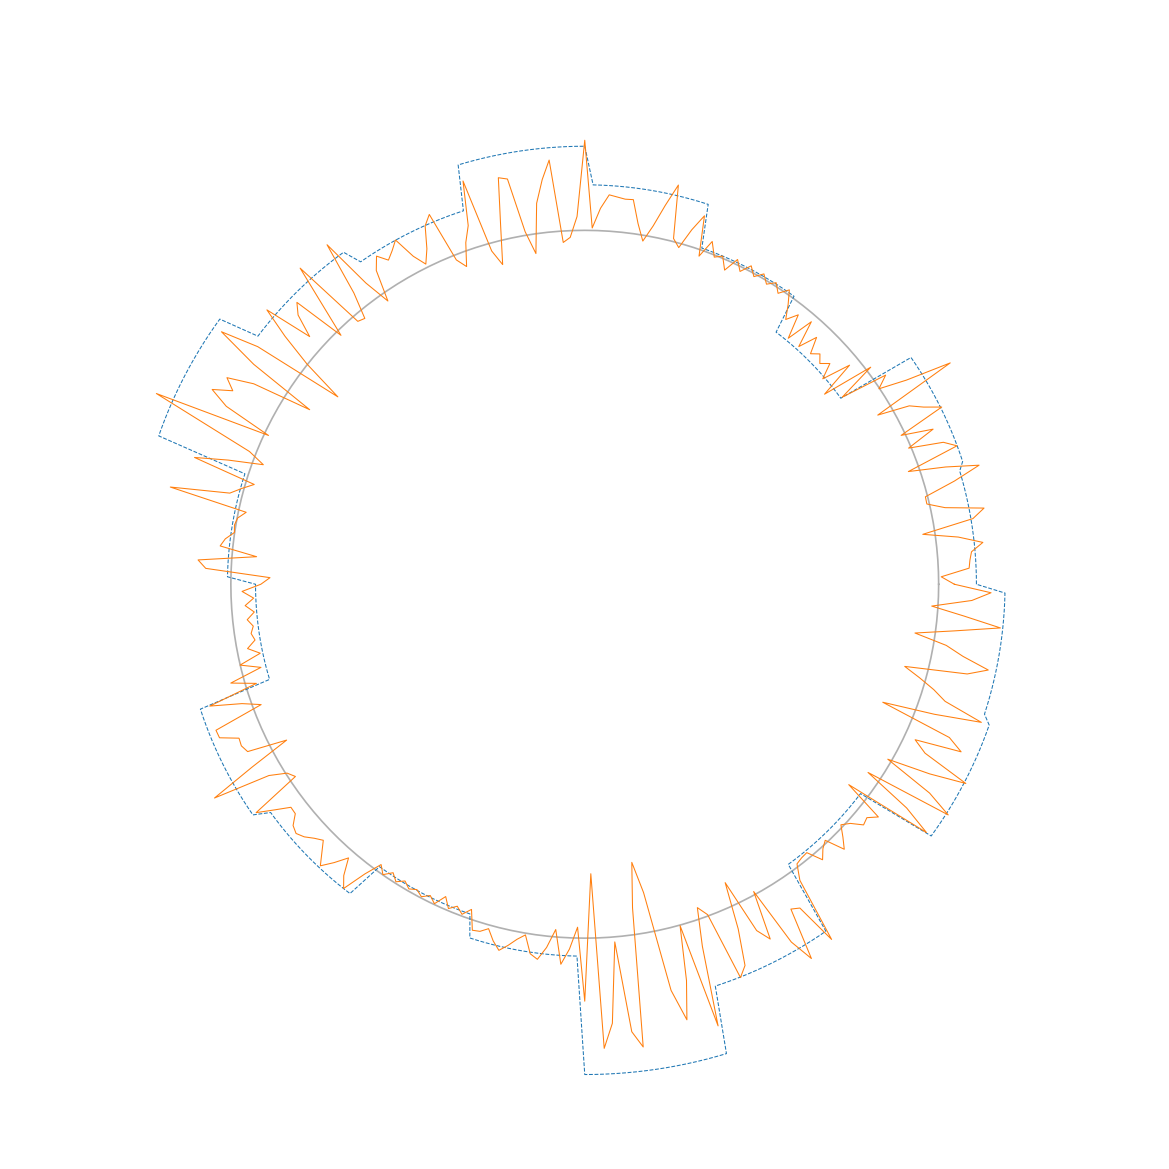

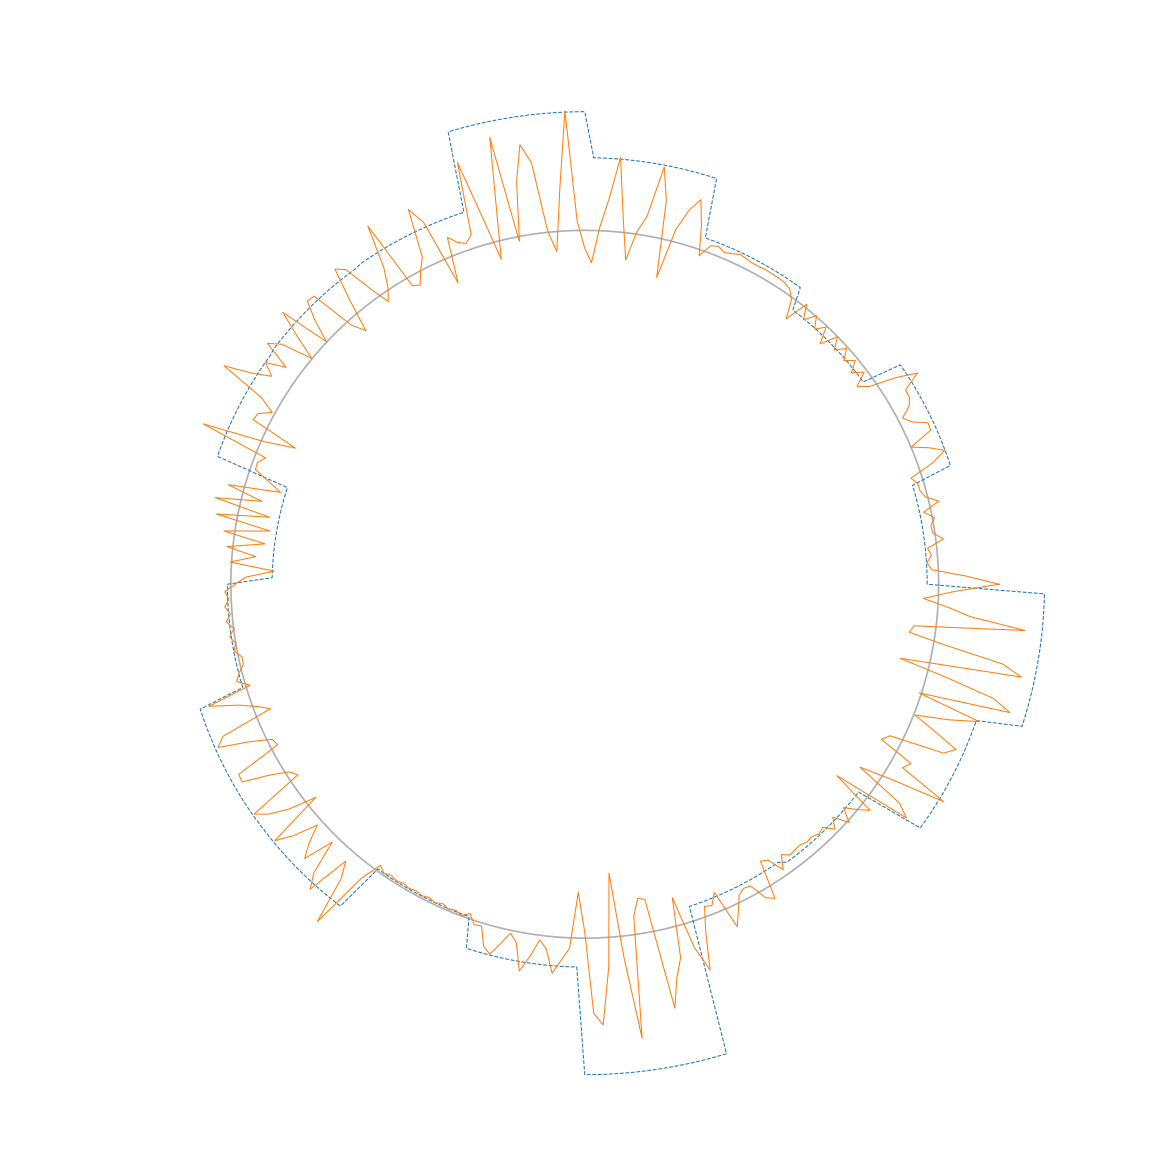

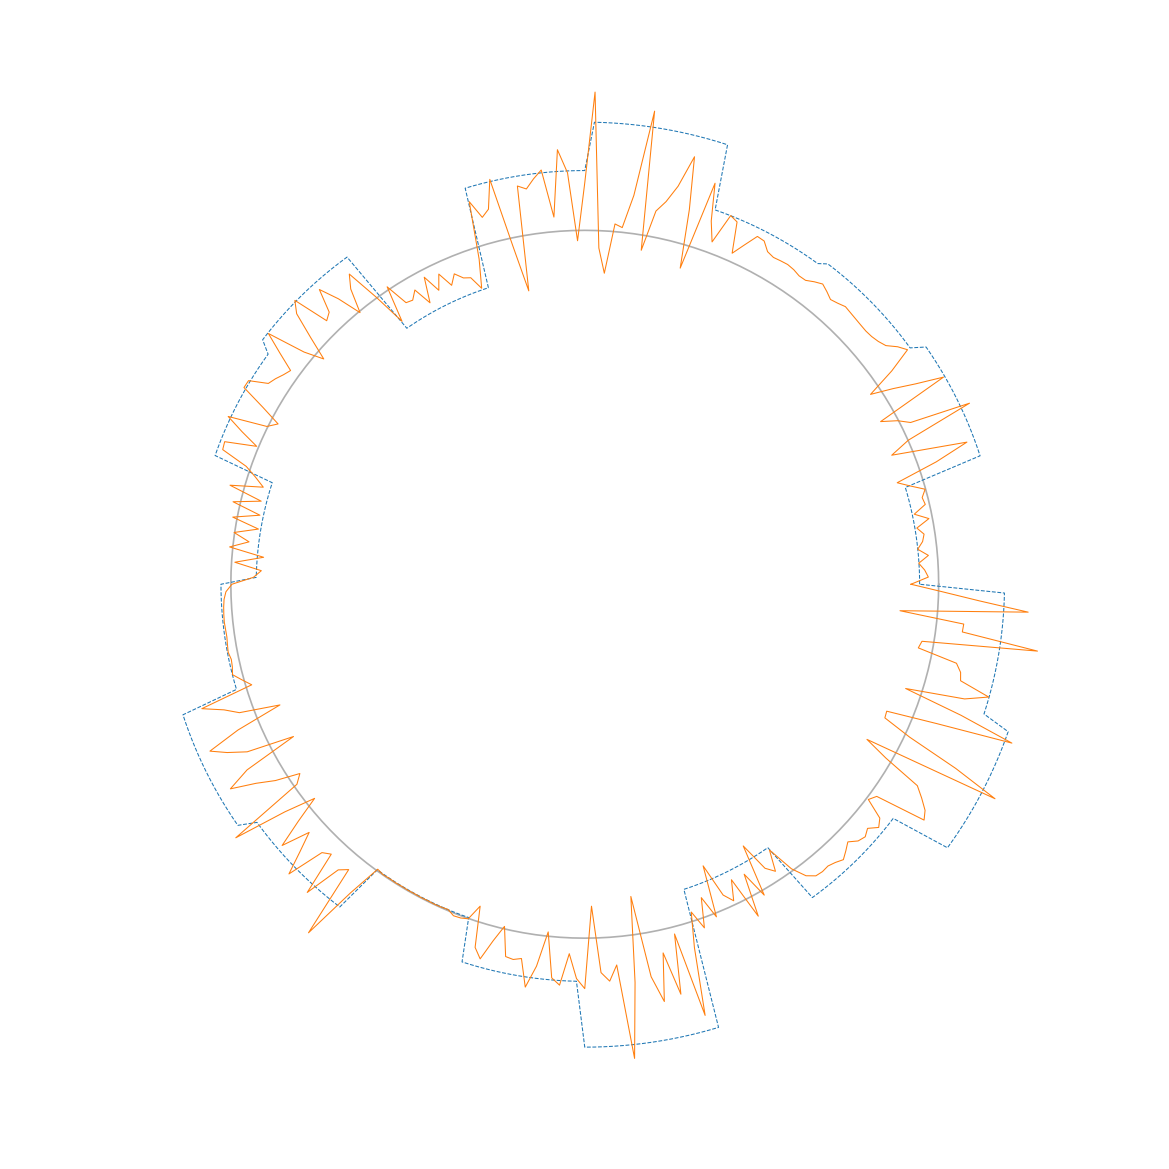

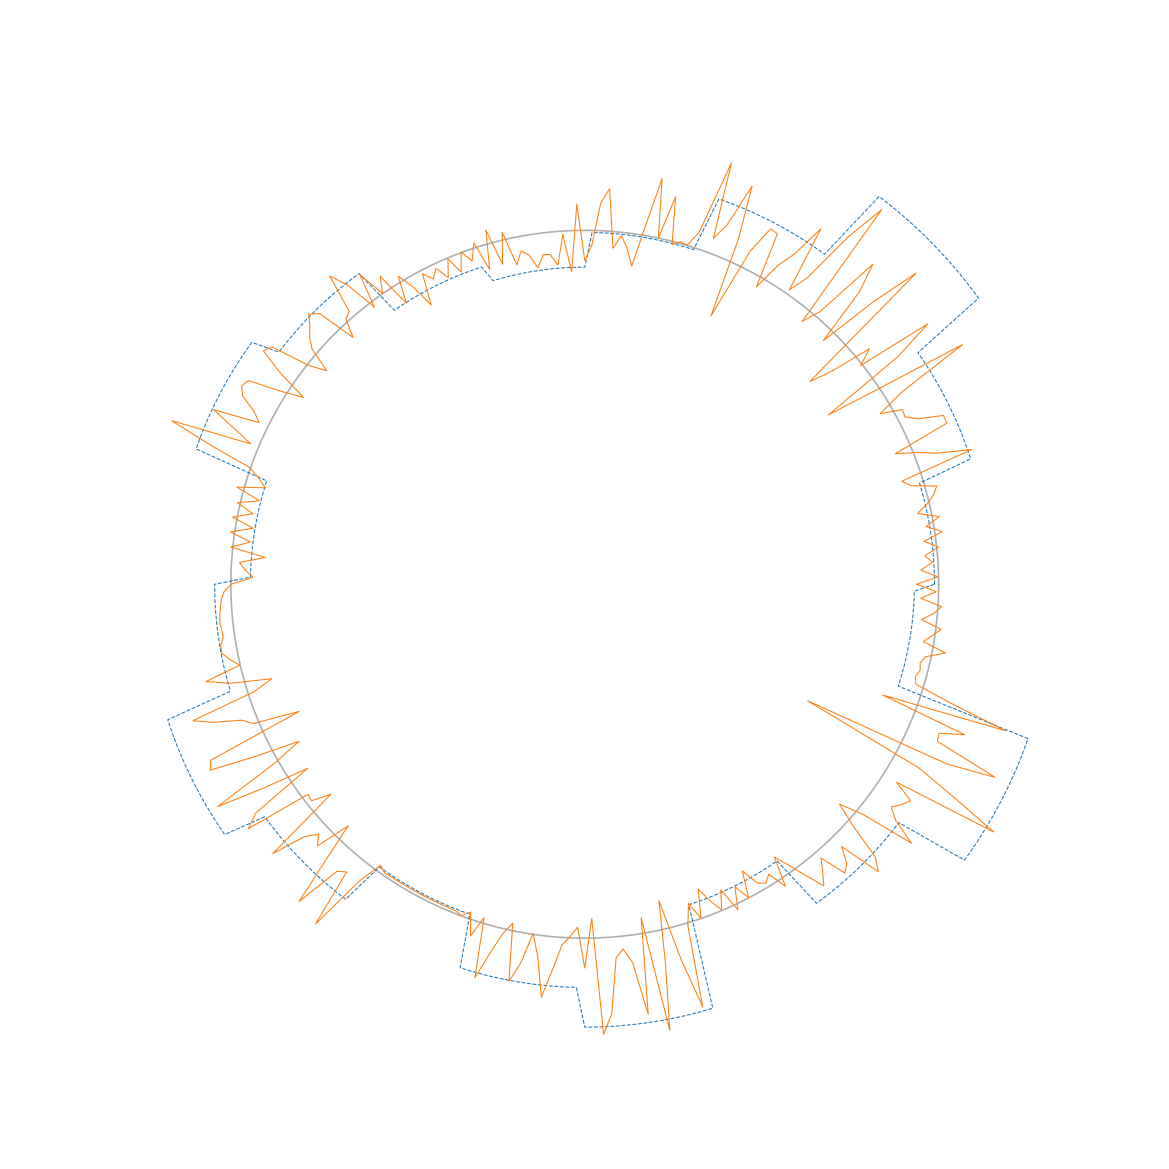

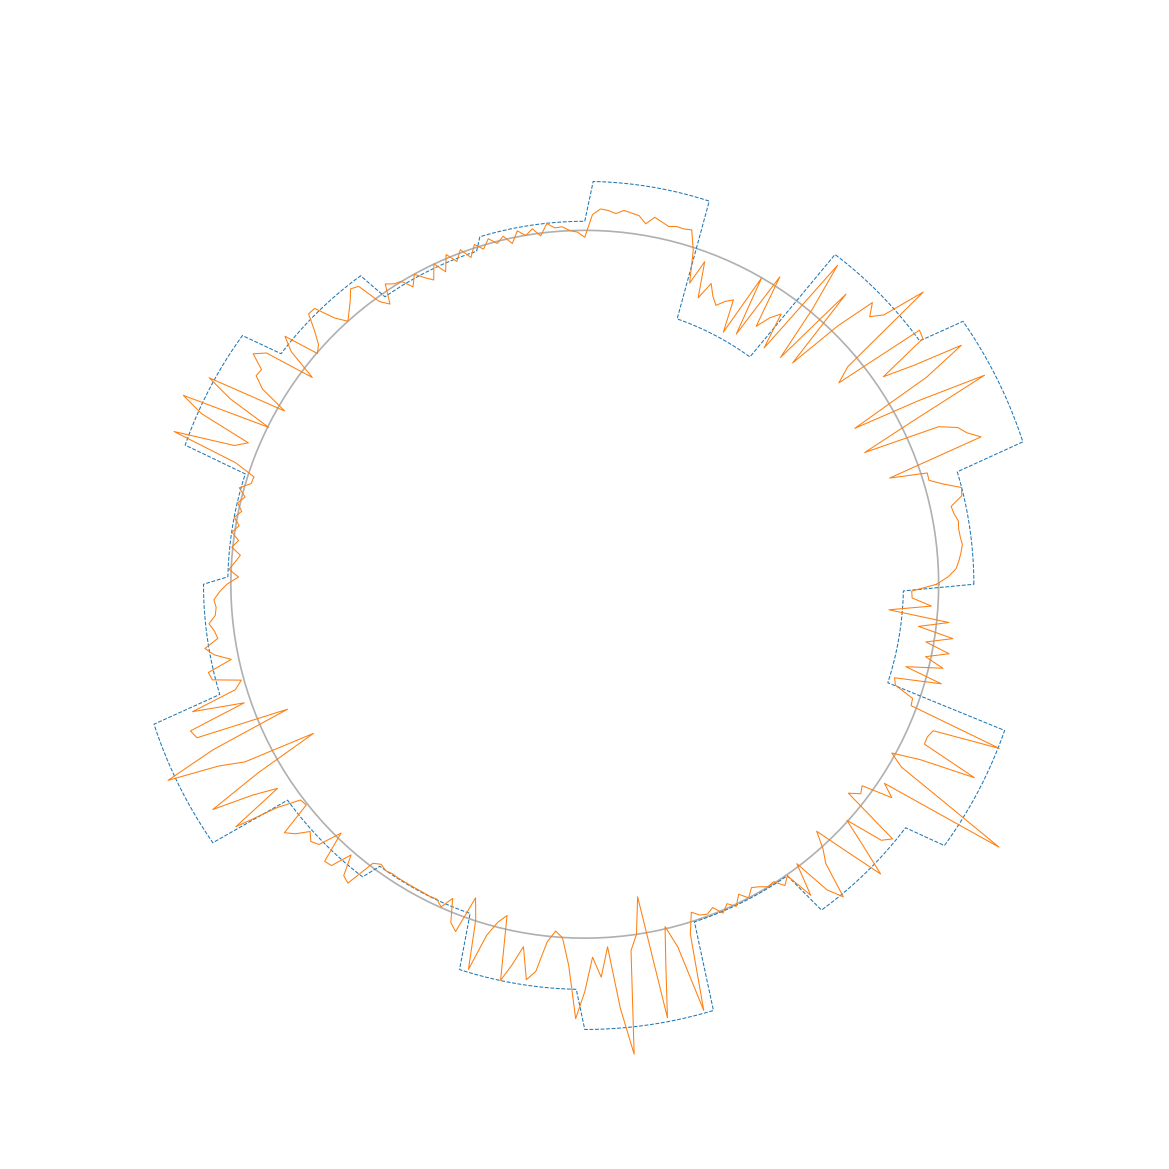

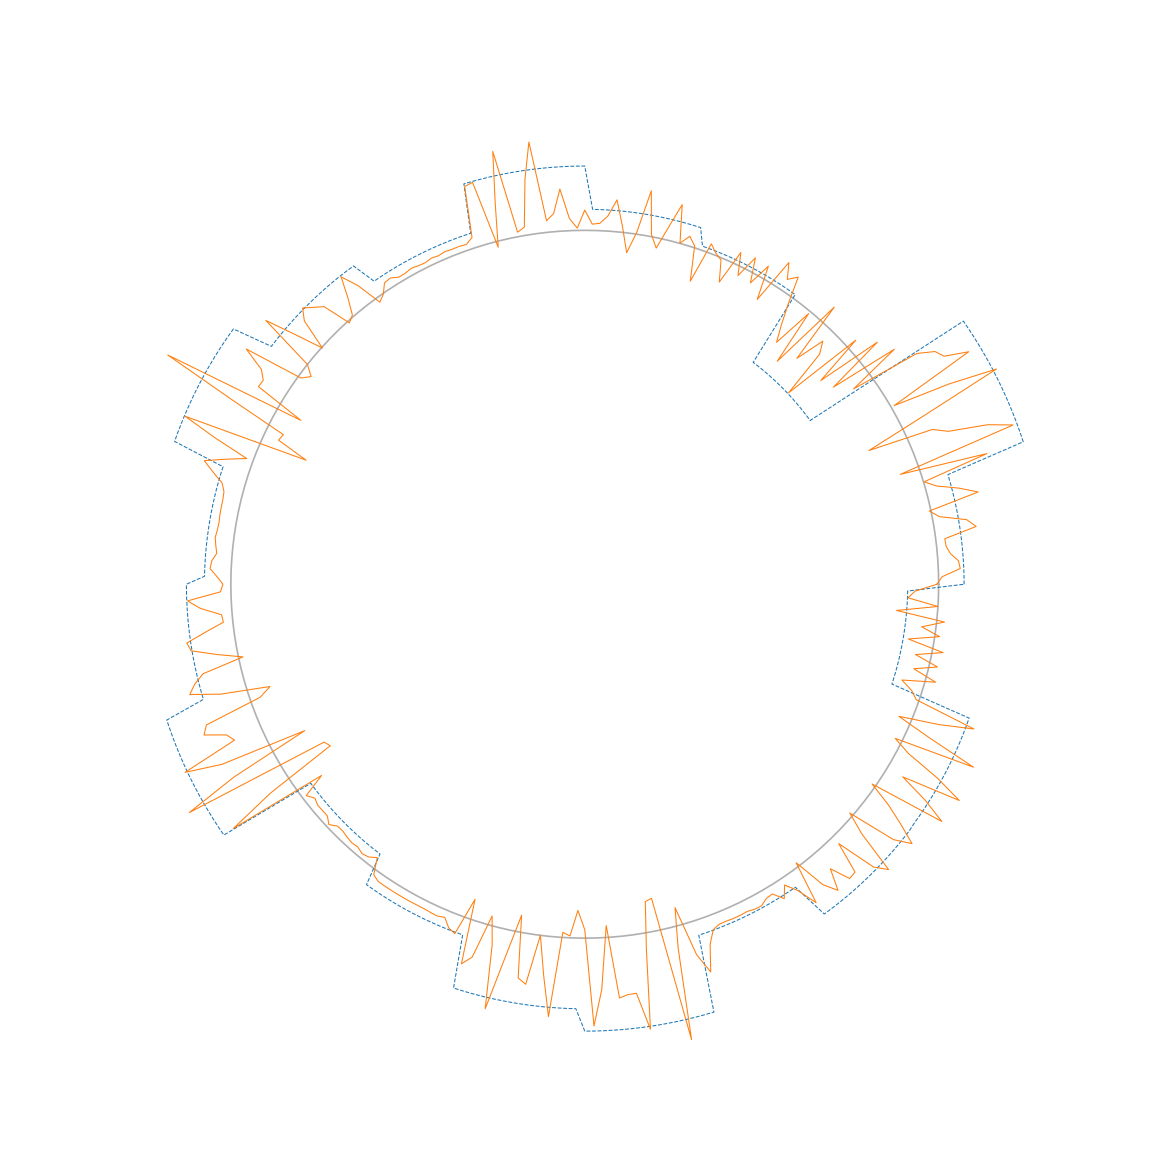

In [88]:
for ii in range(20): #range(XY.shape[0]):
    ii = 5 * ii
    X_to_plot = .1 * XY[ii, 0, :]
    X_to_plot = np.repeat(X_to_plot, J)
    X_to_plot = np.concatenate([X_to_plot,
                                [X_to_plot[0]]])
    Y_to_plot = XY[ii, 1:, :].ravel()
    Y_to_plot = np.concatenate([Y_to_plot, 
                                [Y_to_plot[0]]])
    
    plt.figure(figsize=(10,10), dpi=150)
    axes = plt.subplot(111, polar=True)
    plt.polar(theta_JK, X_to_plot, '--', linewidth=0.5)
    plt.polar(theta_JK, Y_to_plot, linewidth=0.5)
    plt.yticks([0])
    plt.ylim([-2.5, 1.5])
    axes.set_yticklabels([])
    plt.xticks([])
    axes.spines['polar'].set_visible(False)

    
# for ii in range(2000): #range(XY.shape[0]):
#     X_to_plot = .1 * XY[ii, 0, :]
#     X_to_plot = np.repeat(X_to_plot, J)
#     X_to_plot = np.concatenate([X_to_plot,
#                                 [X_to_plot[0]]])
#     Y_to_plot = XY[ii, 1:, :].ravel()
#     Y_to_plot = np.concatenate([Y_to_plot, 
#                                 [Y_to_plot[0]]])
    
#     plt.figure(figsize=(10,10), dpi=150)
#     axes = plt.subplot(111, polar=True)
#     plt.polar(theta_JK, X_to_plot, '--', linewidth=0.5)
#     plt.polar(theta_JK, Y_to_plot, linewidth=0.5)
#     plt.yticks([0])
#     plt.ylim([-2.5, 1.5])
#     axes.set_yticklabels([])
#     plt.xticks([])
#     axes.spines['polar'].set_visible(False)
#     plt.savefig(f'/home2/travis/python_code/multi_loc/movies/smaller_L96/zfig{ii:06}')
#     plt.close('all')

In [430]:
# np.save('./XY_long_run.npy', XY)

In [254]:
# XY = np.load('./XY.npy')

In [30]:
XY_ravel = XY.reshape(XY.shape[0], (J + 1)*K).T

In [ ]:
ts = np.random.choice(t.size, size=(N_ec + 1)*N_ef, replace=False)
ts_coarse = ts[:N_ec]
ts_fine = tx[N_ec:]
Y_sample = Y_long[:, ts]

XY_ens

In [31]:
X_long = XY[:, 0, :].T
Y_long = XY[:, 1:, :].reshape(XY.shape[0], J*K).T

In [32]:
P_X = np.cov(X_long)
P_Y = np.cov(Y_long)

In [33]:
P_XY = np.cov(XY_ravel)

In [34]:
%matplotlib inline

In [35]:
D_inv = np.diag(np.sqrt(1/np.diag(P_XY)))
rho_XY = D_inv @ P_XY @ D_inv

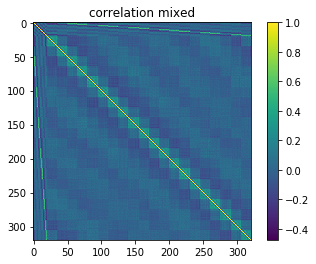

In [36]:
imshow(rho_XY, title='correlation mixed')

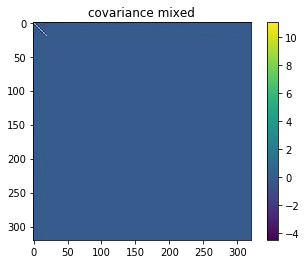

In [37]:
imshow(P_XY, title='covariance mixed')

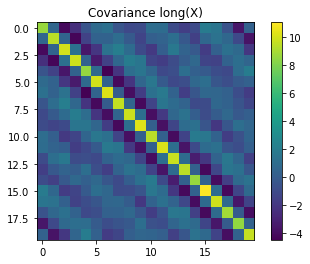

In [38]:
imshow(P_X, title='Covariance long(X)')

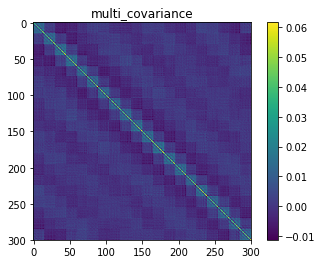

In [39]:
imshow(P_Y, title='multi_covariance')

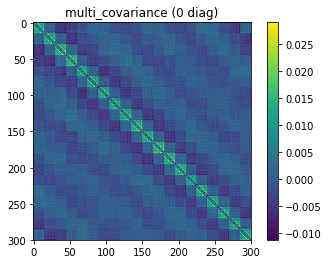

In [40]:
imshow(P_Y - np.diag(np.diag(P_Y)), title='multi_covariance (0 diag)')

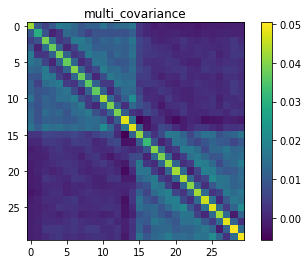

In [41]:
imshow(P_Y[:30, :30], title='multi_covariance')

In [42]:
H_subgrid = np.eye(P_X.shape[0])
R_subgrid = 1 * np.eye(P_X.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=P_X,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_X'
    print(key)
    exec(key + '=val')

P_sqrt_X
P_inv_sqrt_X
R_sqrt_X
R_inv_sqrt_X
U_X
S_X
VT_X
H_X
Tx_X
Tx_inv_X
Ty_X
Ty_inv_X


In [43]:
U_X_interp = np.repeat(U_X, J, axis=0)/np.sqrt(J)
VT_X_interp = np.repeat(VT_X, J, axis=1)/np.sqrt(J)

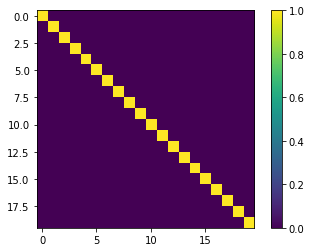

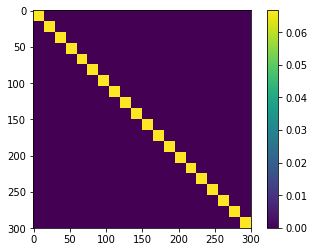

In [44]:
imshow(VT_X_interp @ VT_X_interp.T)
imshow(VT_X_interp.T @ VT_X_interp)

In [45]:
%matplotlib inline

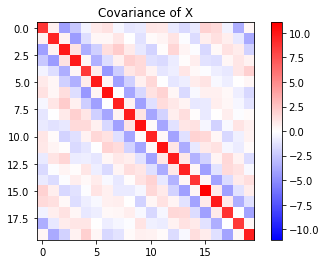

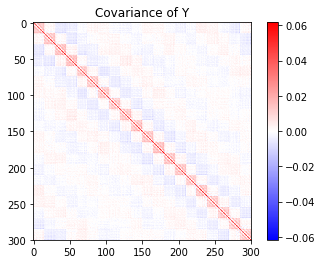

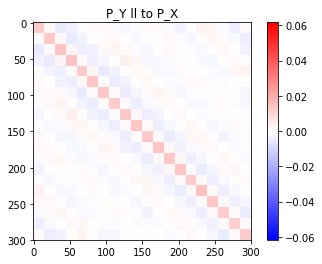

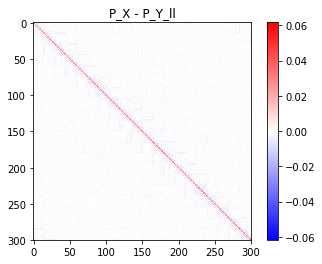

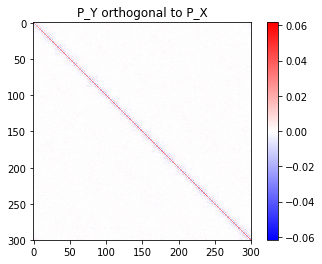

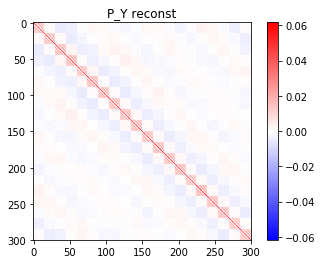

In [49]:
proj0 = VT_X_interp.T @ VT_X_interp

# P_Y_ll_X = (VT_X_interp.T
#         @ np.diag(np.diag(VT_X_interp @ P_Y @ VT_X_interp.T))
#         @ VT_X_interp)
P_Y_ll_X = proj0 @ P_Y @ proj0
# P_Y_ll_X1 = (VT_X_interp.T
#         @ VT_X_interp @ P_Y @ VT_X_interp.T
#         @ VT_X_interp)

diff = P_Y - P_Y_ll_X

# proj = np.eye(J * K) - VT_X_interp.T @ VT_X_interp
proj = np.eye(J * K) - proj0

P_Y_orth_X = proj @ P_Y @ proj

P_Y_reconst0 = P_Y_ll_X + P_Y_orth_X

vmax = np.max(
    [np.abs(P_Y).max(),
     np.abs(diff).max(),
     np.abs(P_Y_ll_X).max(),
     np.abs(P_Y_orth_X).max(),
     np.abs(P_Y_reconst0).max()])
vmax_X = np.abs(P_X).max()

imshow(P_X, vmax=vmax_X, vmin=-vmax_X, cmap='bwr',
       title='Covariance of X')
imshow(P_Y, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Covariance of Y')
imshow(P_Y_ll_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y ll to P_X')
imshow(diff, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_X - P_Y_ll')
imshow(P_Y_orth_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y orthogonal to P_X')
imshow(P_Y_reconst0, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y reconst')

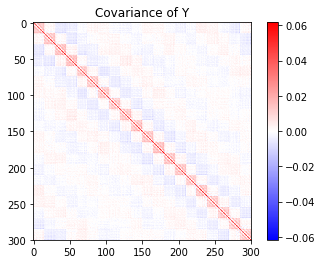

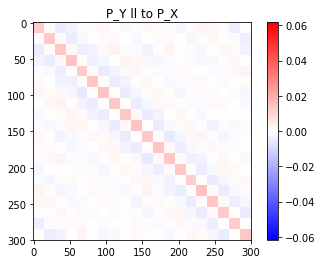

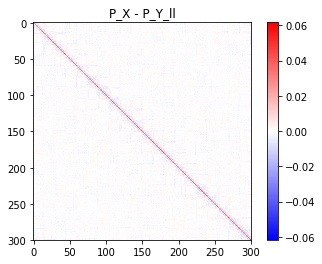

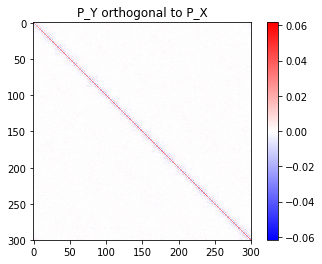

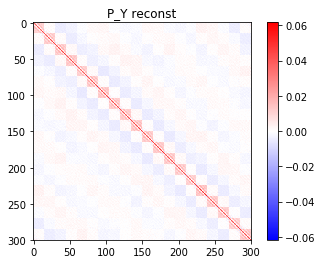

In [50]:
proj0 = VT_X_interp.T @ VT_X_interp

P_Y_ll_X = (VT_X_interp.T
        @ np.diag(np.diag(VT_X_interp @ P_Y @ VT_X_interp.T))
        @ VT_X_interp)
# P_Y_ll_X = proj0 @ P_Y @ proj0
# P_Y_ll_X1 = (VT_X_interp.T
#         @ VT_X_interp @ P_Y @ VT_X_interp.T
#         @ VT_X_interp)

diff = P_Y - P_Y_ll_X

proj = np.eye(J * K) - VT_X_interp.T @ VT_X_interp

P_Y_orth_X = proj @ P_Y @ proj

P_Y_reconst0 = P_Y_ll_X + P_Y_orth_X

vmax = np.max(
    [np.abs(P_Y).max(),
     np.abs(diff).max(),
     np.abs(P_Y_ll_X).max(),
     np.abs(P_Y_orth_X).max(),
     np.abs(P_Y_reconst0).max()])

imshow(P_Y, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Covariance of Y')
imshow(P_Y_ll_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y ll to P_X')
imshow(diff, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_X - P_Y_ll')
imshow(P_Y_orth_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y orthogonal to P_X')
imshow(P_Y_reconst0, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y reconst')

In [51]:
ens_size = 20
ts = np.random.choice(t.size, size=ens_size, replace=False)
Y_sample = Y_long[:, ts]

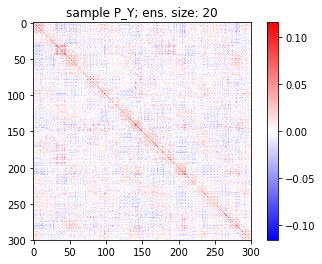

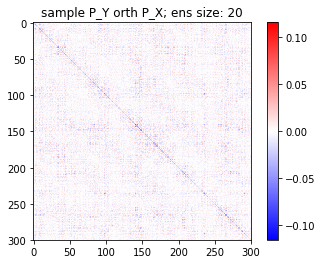

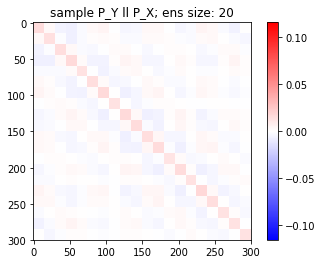

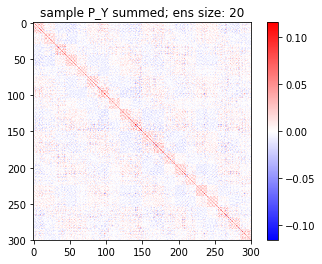

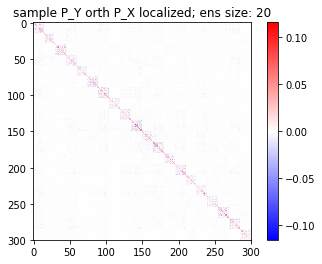

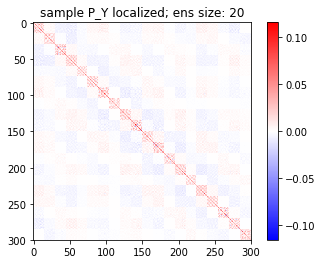

In [52]:
P_Y_sample = np.cov(Y_sample)
P_Y_sample_orth = proj @ P_Y_sample @ proj
P_Y_sample_ll = (
    VT_X_interp.T
    @ np.diag(np.diag(VT_X_interp @ P_Y_sample @ VT_X_interp.T))
    @ VT_X_interp)

# P_Y_sample_ll = (
#     VT_X_interp.T
#     @ VT_X_interp @ P_Y_sample @ VT_X_interp.T
#     @ VT_X_interp)
P_Y_sample_sum = P_Y_sample_orth + P_Y_sample_ll
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(P_Y_sample_ll)))
rho_Y_sample_ll = D_inv_sqrt @ P_Y_sample_ll @ D_inv_sqrt
P_Y_sample_orth_loc = rho_Y_sample_ll * P_Y_sample_orth
P_Y_sample_loc = rho_Y_sample_ll * P_Y_sample_orth + P_Y_sample_ll

vmax = np.max([
    np.abs(P_Y_sample).max(),
    np.abs(P_Y_sample_orth).max(),
    np.abs(P_Y_sample_ll).max(),
    np.abs(P_Y_sample_sum).max(),
    np.abs(P_Y_sample_loc).max(),
    np.abs(P_Y_sample_orth_loc).max()])
imshow(P_Y_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y; ens. size: {ens_size}')
imshow(P_Y_sample_orth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y orth P_X; ens size: {ens_size}')
imshow(P_Y_sample_ll,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y ll P_X; ens size: {ens_size}')
imshow(P_Y_sample_sum,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y summed; ens size: {ens_size}')
imshow(P_Y_sample_orth_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y orth P_X localized; ens size: {ens_size}')
imshow(P_Y_sample_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample P_Y localized; ens size: {ens_size}')

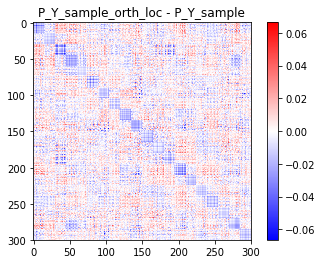

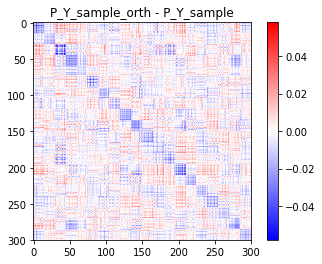

In [53]:
this_diff = P_Y_sample_orth_loc - P_Y_sample
vmax = np.abs(this_diff).max()
imshow(this_diff,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y_sample_orth_loc - P_Y_sample')

this_diff = P_Y_sample_orth - P_Y_sample
vmax = np.abs(this_diff).max()
imshow(this_diff,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y_sample_orth - P_Y_sample')

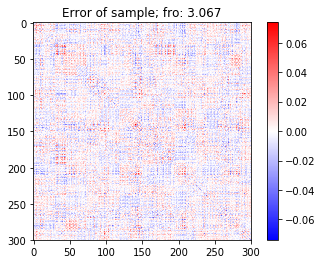

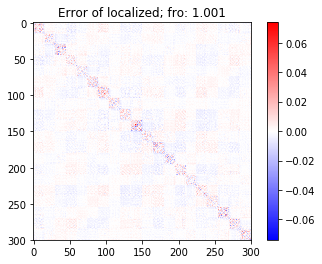

In [54]:
error_sample = P_Y_sample - P_Y
fro_sample = np.round(
    np.linalg.norm(error_sample, ord='fro'),
    decimals=3)
error_localized = P_Y_sample_loc - P_Y
fro_localized = np.round(
    np.linalg.norm(error_localized, ord='fro'),
    decimals=3)
vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_localized).max()
])
imshow(error_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of sample; fro: {fro_sample}')
imshow(error_localized,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of localized; fro: {fro_localized}')

In [55]:
def D_KL(P, Q):
    Q_inv = np.linalg.inv(Q)
    tr = np.trace(Q_inv @ P)
    k = np.shape(P)[0]
    Q_det = np.linalg.det(Q)
    P_det = np.linalg.det(P)
    KL = tr - k + np.log(Q_det/P_det)
    return KL

In [56]:
def loc_error(P, P_sample, rho0, norm='fro'):
    [loc] = covariance.generate_circulant(
        J * K, 1.0, rho0, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_sort_ind=False, return_eig=False)
    P_loc = P_sample * loc
    error = P_loc - P
    error = np.linalg.norm(error, ord=norm)
    return error, P_loc

Text(0.5, 1.0, 'Error (2) vs. rho')

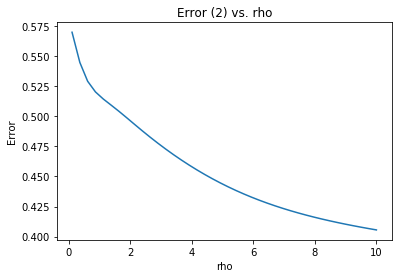

In [57]:
norm = 2
rho_array = np.linspace(.1, 10, 40)
error_array = np.ones_like(rho_array) * np.nan
for count, rho0 in enumerate(rho_array):
    error_array[count], P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0, norm=norm)
    
plt.figure()
plt.plot(rho_array, error_array)
plt.ylabel('Error')
plt.xlabel('rho')
plt.title(f'Error ({norm}) vs. rho')

Text(0.5, 1.0, 'Error (fro) vs. rho')

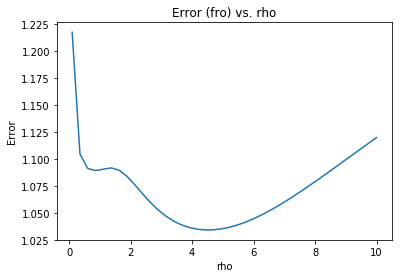

In [58]:
norm = 'fro'
rho_array = np.linspace(.1, 10, 40)
error_array = np.ones_like(rho_array) * np.nan
for count, rho0 in enumerate(rho_array):
    error_array[count], P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0, norm=norm)
    
plt.figure()
plt.plot(rho_array, error_array)
plt.ylabel('Error')
plt.xlabel('rho')
plt.title(f'Error ({norm}) vs. rho')

In [59]:
rho0 = rho_array[np.argmin(error_array)]
err, P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0)

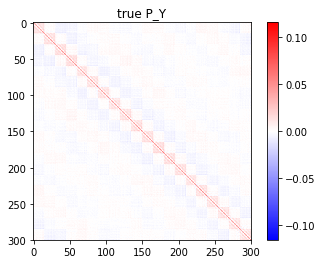

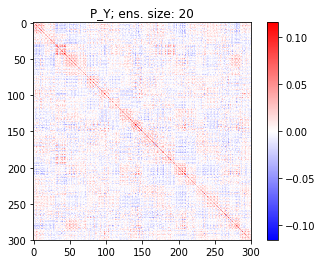

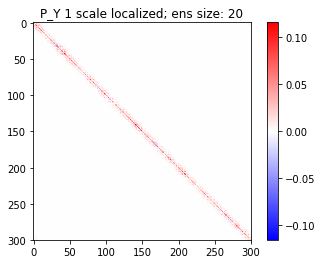

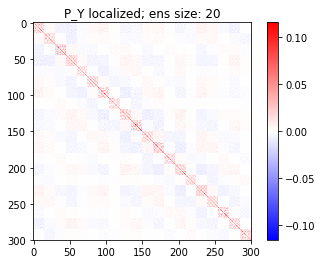

In [60]:
# Plot of Covarainces
vmax = np.max([
    np.abs(P_Y).max(),
    np.abs(P_Y_sample).max(),
    np.abs(P_Y_1_loc).max(),
    np.abs(P_Y_sample_loc).max()])
imshow(P_Y,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'true P_Y')
imshow(P_Y_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y; ens. size: {ens_size}')
imshow(P_Y_1_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y 1 scale localized; ens size: {ens_size}')
imshow(P_Y_sample_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y localized; ens size: {ens_size}')

Text(0.5, 1.0, 'Variance of system')

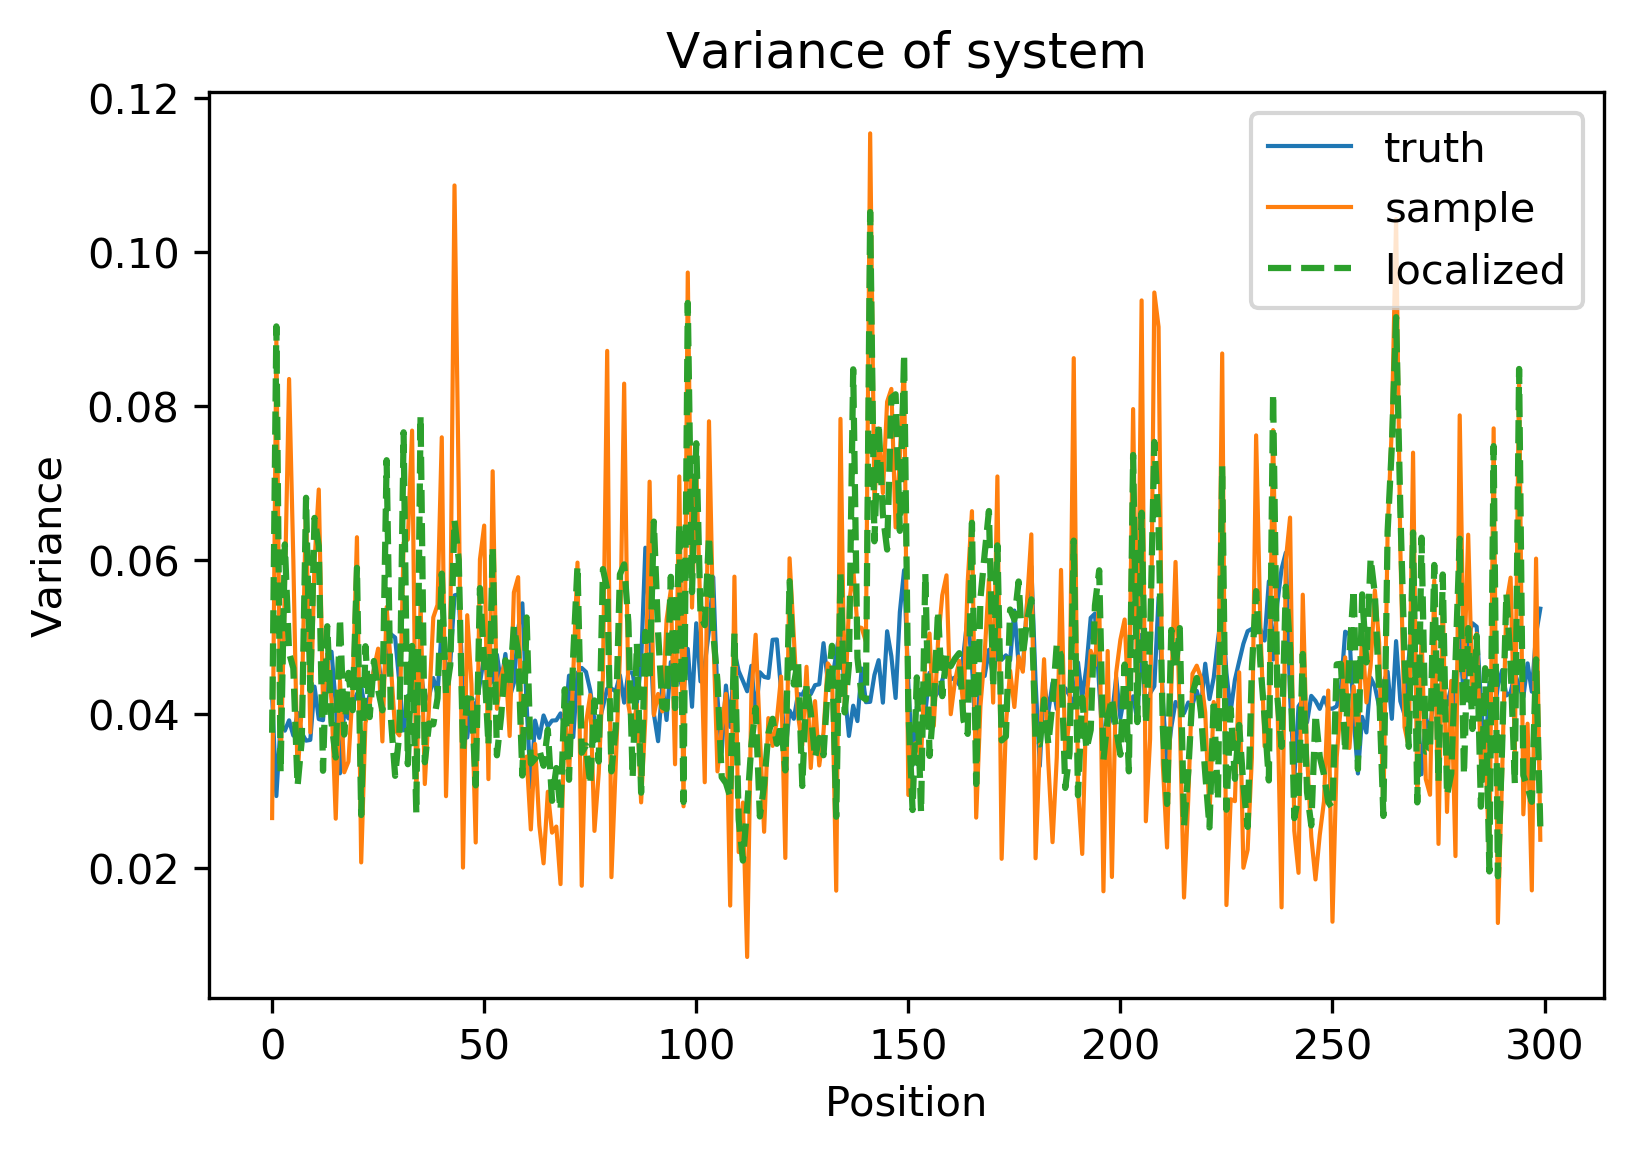

In [61]:
plt.figure(dpi=300)
plt.plot(P_Y.diagonal(), linewidth=1)
plt.plot(P_Y_sample.diagonal(), linewidth=1)
plt.plot(P_Y_sample_loc.diagonal(), linestyle='--')
plt.legend(['truth',
            'sample',
            'localized',
            '1 scale loc'])
plt.xlabel('Position')
plt.ylabel('Variance')
plt.title('Variance of system')

In [62]:
error_1_loc = P_Y_1_loc - P_Y
fro_1_loc = np.round(
    np.linalg.norm(error_1_loc, ord='fro'),
    decimals=3)

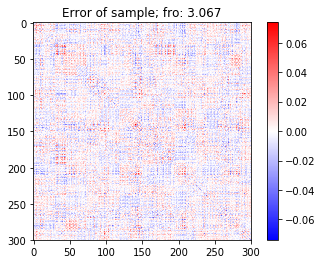

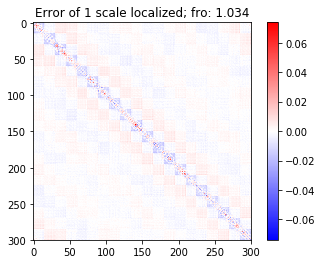

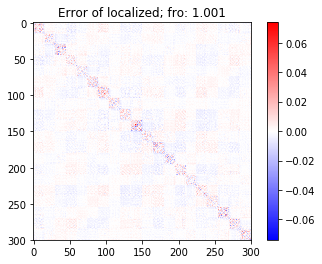

In [63]:
vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_localized).max(),
    np.abs(error_1_loc).max()
])
imshow(error_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of sample; fro: {fro_sample}')
imshow(error_1_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of 1 scale localized; fro: {fro_1_loc}')
imshow(error_localized,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of localized; fro: {fro_localized}')

In [382]:
fro_localized = np.round(
    np.linalg.norm(error_localized, ord=2),
    decimals=3)
fro_1_loc = np.round(
    np.linalg.norm(error_1_loc, ord='fro'),
    decimals=3)
print(f'multi_loc error, frobenius norm: {fro_localized}')
print(f'one scale error, frobenius norm: {fro_1_loc}')

multi_loc error, frobenius norm: 0.264
one scale error, frobenius norm: 0.566


# Correlation not covariance

In [361]:
C_X = np.corrcoef(X_long)
C_Y = np.corrcoef(Y_long)

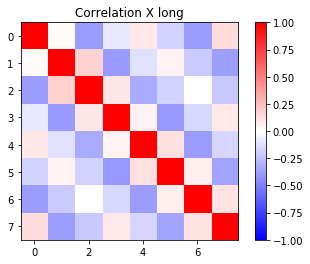

In [356]:
vmax = np.abs(C_X).max()
imshow(C_X,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Correlation X long')

In [357]:
H_subgrid = np.eye(P_X.shape[0])
R_subgrid = 1 * np.eye(P_X.shape[0])
trans_mats = assimilate.transformation_matrices(
    H_subgrid, P=C_X,
    R=R_subgrid, return_Ts=True)

for key, val in trans_mats.items():
    key = key + '_X'
    print(key)
    exec(key + '=val')

P_sqrt_X
P_inv_sqrt_X
R_sqrt_X
R_inv_sqrt_X
U_X
S_X
VT_X
H_X
Tx_X
Tx_inv_X
Ty_X
Ty_inv_X


In [358]:
U_X_interp = np.repeat(U_X, J, axis=0)/np.sqrt(J)
VT_X_interp = np.repeat(VT_X, J, axis=1)/np.sqrt(J)

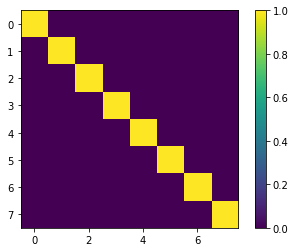

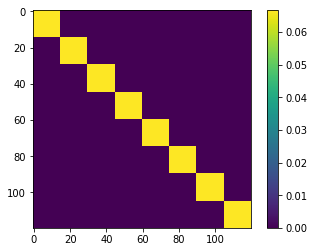

In [359]:
imshow(VT_X_interp @ VT_X_interp.T)
imshow(VT_X_interp.T @ VT_X_interp)

Text(0.5, 1.0, 'Sum of Diagonals')

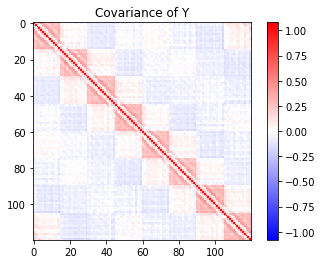

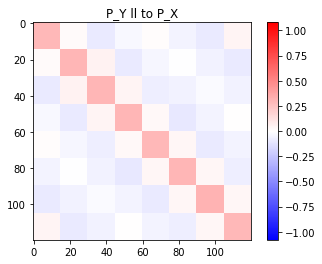

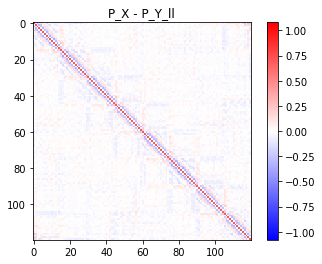

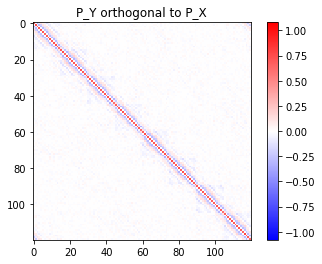

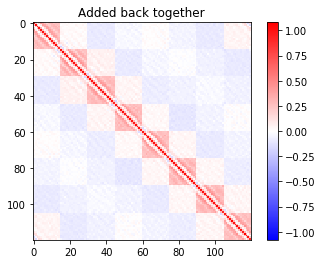

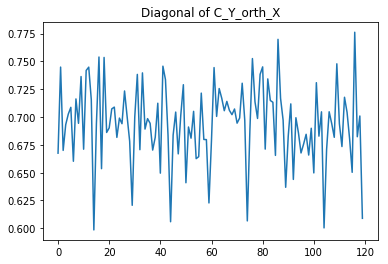

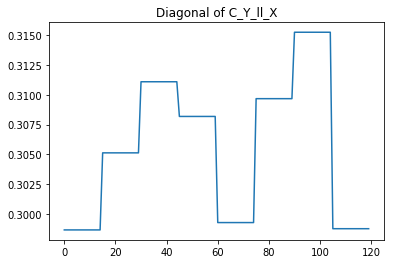

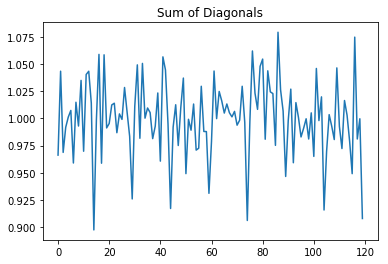

In [396]:
C_Y_ll_X = (VT_X_interp.T
        @ np.diag(np.diag(VT_X_interp @ C_Y @ VT_X_interp.T))
        @ VT_X_interp)
# C_Y_ll_X = (VT_X_interp.T
#         @ VT_X_interp @ C_Y @ VT_X_interp.T
#         @ VT_X_interp)
diff = C_Y - C_Y_ll_X

proj = np.eye(J * K) - VT_X_interp.T @ VT_X_interp

C_Y_orth_X = proj @ C_Y @ proj

C_Y_sum = C_Y_ll_X + C_Y_orth_X

vmax = np.max(
    [np.abs(C_Y).max(),
     np.abs(diff).max(),
     np.abs(C_Y_ll_X).max(),
     np.abs(C_Y_orth_X).max(),
     np.abs(C_Y_sum).max()])

imshow(C_Y, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Covariance of Y')
imshow(C_Y_ll_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y ll to P_X')
imshow(diff, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_X - P_Y_ll')
imshow(C_Y_orth_X, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y orthogonal to P_X')
imshow(C_Y_sum, vmax=vmax, vmin=-vmax, cmap='bwr',
       title='Added back together')

plt.figure()
plt.plot(np.diag(C_Y_orth_X))
plt.title('Diagonal of C_Y_orth_X')

plt.figure()
plt.plot(np.diag(C_Y_ll_X))
plt.title('Diagonal of C_Y_ll_X')

plt.figure()
plt.plot(np.diag(C_Y_sum))
plt.title('Sum of Diagonals')

In [415]:
ens_size = 20
ts = np.random.choice(t.size, size=ens_size, replace=False)

Y_sample = Y_long[:, ts]

In [399]:
print(np.abs(C_Y_sample).max())
print(np.abs(C_Y_sample_orth).max())
print(np.abs(C_Y_sample_ll).max())
print(np.abs(C_Y_sample_sum).max())
print(np.abs(C_Y_sample_loc).max())
print(np.abs(C_Y_sample_orth_loc).max())

1.0
1.2153685891306771
0.39250094283493636
1.5398519081848687
1.5398519081848687
1.2153685891306771


In [408]:
np.linalg.norm(C_Y_sample)

33.227446171676114

In [409]:
np.linalg.norm(proj @ C_Y_sample @ proj, ord=2)

8.081538976811498

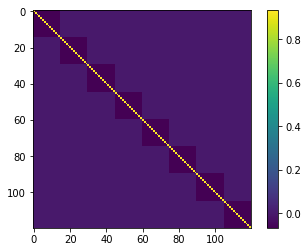

In [406]:
imshow(proj @ proj)

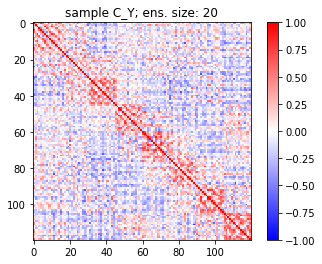

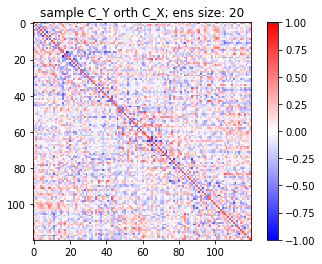

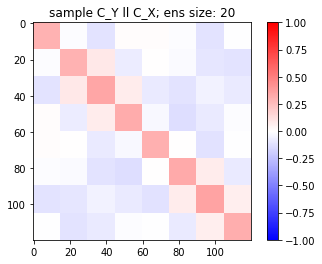

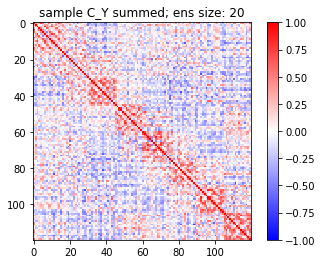

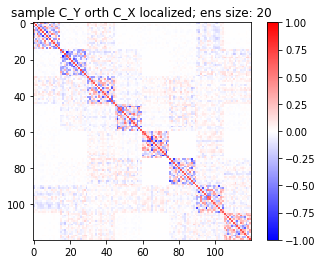

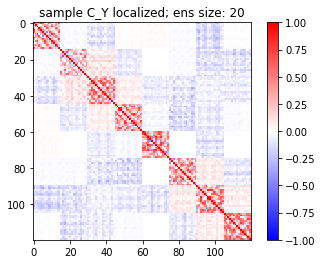

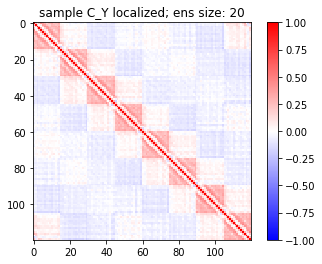

In [416]:
C_Y_sample = np.corrcoef(Y_sample)
# C_Y_sample_orth = proj @ C_Y_sample @ proj
C_Y_sample_ll = (
    VT_X_interp.T
    @ np.diag(np.diag(VT_X_interp @ C_Y_sample @ VT_X_interp.T))
    @ VT_X_interp)
C_Y_sample_orth = C_Y_sample - C_Y_sample_ll
C_Y_sample_sum = C_Y_sample_orth + C_Y_sample_ll
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(C_Y_sample_ll)))
rho_Y_sample_ll = D_inv_sqrt @ C_Y_sample_ll @ D_inv_sqrt
C_Y_sample_orth_loc = rho_Y_sample_ll * C_Y_sample_orth
C_Y_sample_loc = rho_Y_sample_ll * C_Y_sample_orth + C_Y_sample_ll

vmax = np.max([
    np.abs(C_Y_sample).max(),
    np.abs(C_Y_sample_orth).max(),
    np.abs(C_Y_sample_ll).max(),
    np.abs(C_Y_sample_sum).max(),
    np.abs(C_Y_sample_loc).max(),
    np.abs(C_Y_sample_orth_loc).max()])
imshow(C_Y_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y; ens. size: {ens_size}')
imshow(C_Y_sample_orth,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y orth C_X; ens size: {ens_size}')
imshow(C_Y_sample_ll,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y ll C_X; ens size: {ens_size}')
imshow(C_Y_sample_sum,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y summed; ens size: {ens_size}')
imshow(C_Y_sample_orth_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y orth C_X localized; ens size: {ens_size}')
imshow(C_Y_sample_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y localized; ens size: {ens_size}')
imshow(C_Y,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'sample C_Y localized; ens size: {ens_size}')

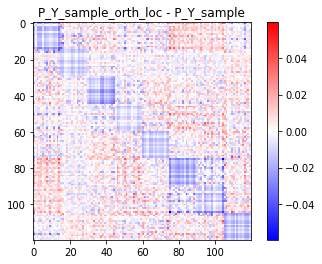

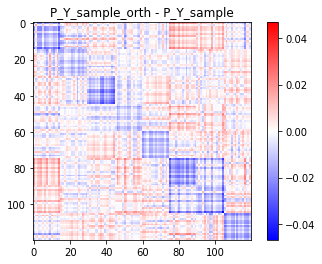

In [352]:
this_diff = P_Y_sample_orth_loc - P_Y_sample
vmax = np.abs(this_diff).max()
imshow(this_diff,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y_sample_orth_loc - P_Y_sample')

this_diff = P_Y_sample_orth - P_Y_sample
vmax = np.abs(this_diff).max()
imshow(this_diff,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title='P_Y_sample_orth - P_Y_sample')

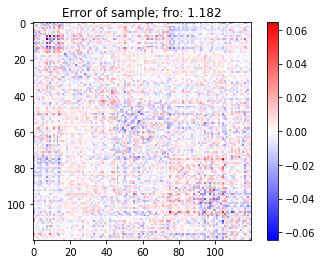

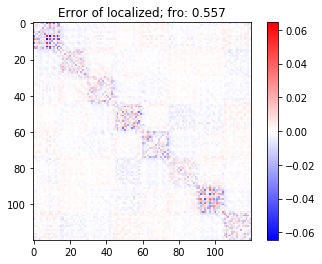

In [338]:
error_sample = P_Y_sample - P_Y
fro_sample = np.round(
    np.linalg.norm(error_sample, ord='fro'),
    decimals=3)
error_localized = P_Y_sample_loc - P_Y
fro_localized = np.round(
    np.linalg.norm(error_localized, ord='fro'),
    decimals=3)
vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_localized).max()
])
imshow(error_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of sample; fro: {fro_sample}')
imshow(error_localized,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of localized; fro: {fro_localized}')

In [339]:
def D_KL(P, Q):
    Q_inv = np.linalg.inv(Q)
    tr = np.trace(Q_inv @ P)
    k = np.shape(P)[0]
    Q_det = np.linalg.det(Q)
    P_det = np.linalg.det(P)
    KL = tr - k + np.log(Q_det/P_det)
    return KL

In [340]:
def loc_error(P, P_sample, rho0, norm='fro'):
    [loc] = covariance.generate_circulant(
        J * K, 1.0, rho0, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_sort_ind=False, return_eig=False)
    P_loc = P_sample * loc
    error = P_loc - P
    error = np.linalg.norm(error, ord=norm)
    return error, P_loc

Text(0.5, 1.0, 'Error (2) vs. rho')

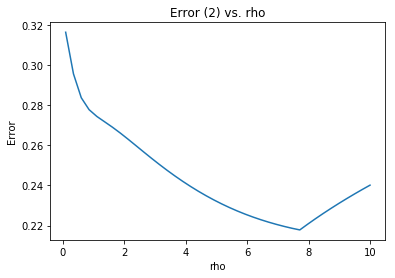

In [341]:
norm = 2
rho_array = np.linspace(.1, 10, 40)
error_array = np.ones_like(rho_array) * np.nan
for count, rho0 in enumerate(rho_array):
    error_array[count], P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0, norm=norm)
    
plt.figure()
plt.plot(rho_array, error_array)
plt.ylabel('Error')
plt.xlabel('rho')
plt.title(f'Error ({norm}) vs. rho')

Text(0.5, 1.0, 'Error (fro) vs. rho')

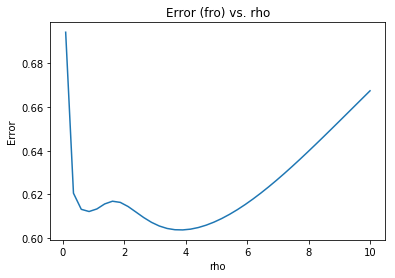

In [342]:
norm = 'fro'
rho_array = np.linspace(.1, 10, 40)
error_array = np.ones_like(rho_array) * np.nan
for count, rho0 in enumerate(rho_array):
    error_array[count], P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0, norm=norm)
    
plt.figure()
plt.plot(rho_array, error_array)
plt.ylabel('Error')
plt.xlabel('rho')
plt.title(f'Error ({norm}) vs. rho')

In [343]:
rho0 = rho_array[np.argmin(error_array)]
err, P_Y_1_loc = loc_error(P_Y, P_Y_sample, rho0)

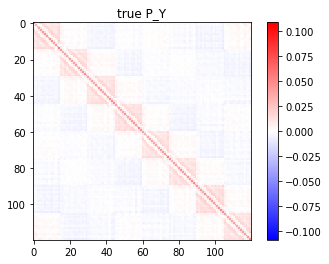

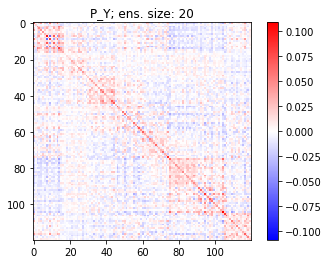

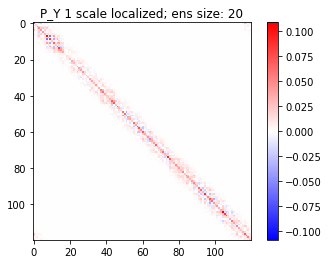

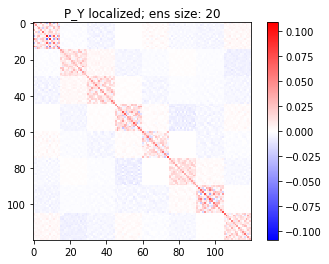

In [344]:
# Plot of Covarainces
vmax = np.max([
    np.abs(P_Y).max(),
    np.abs(P_Y_sample).max(),
    np.abs(P_Y_1_loc).max(),
    np.abs(P_Y_sample_loc).max()])
imshow(P_Y,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'true P_Y')
imshow(P_Y_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y; ens. size: {ens_size}')
imshow(P_Y_1_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y 1 scale localized; ens size: {ens_size}')
imshow(P_Y_sample_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'P_Y localized; ens size: {ens_size}')

Text(0.5, 1.0, 'Variance of system')

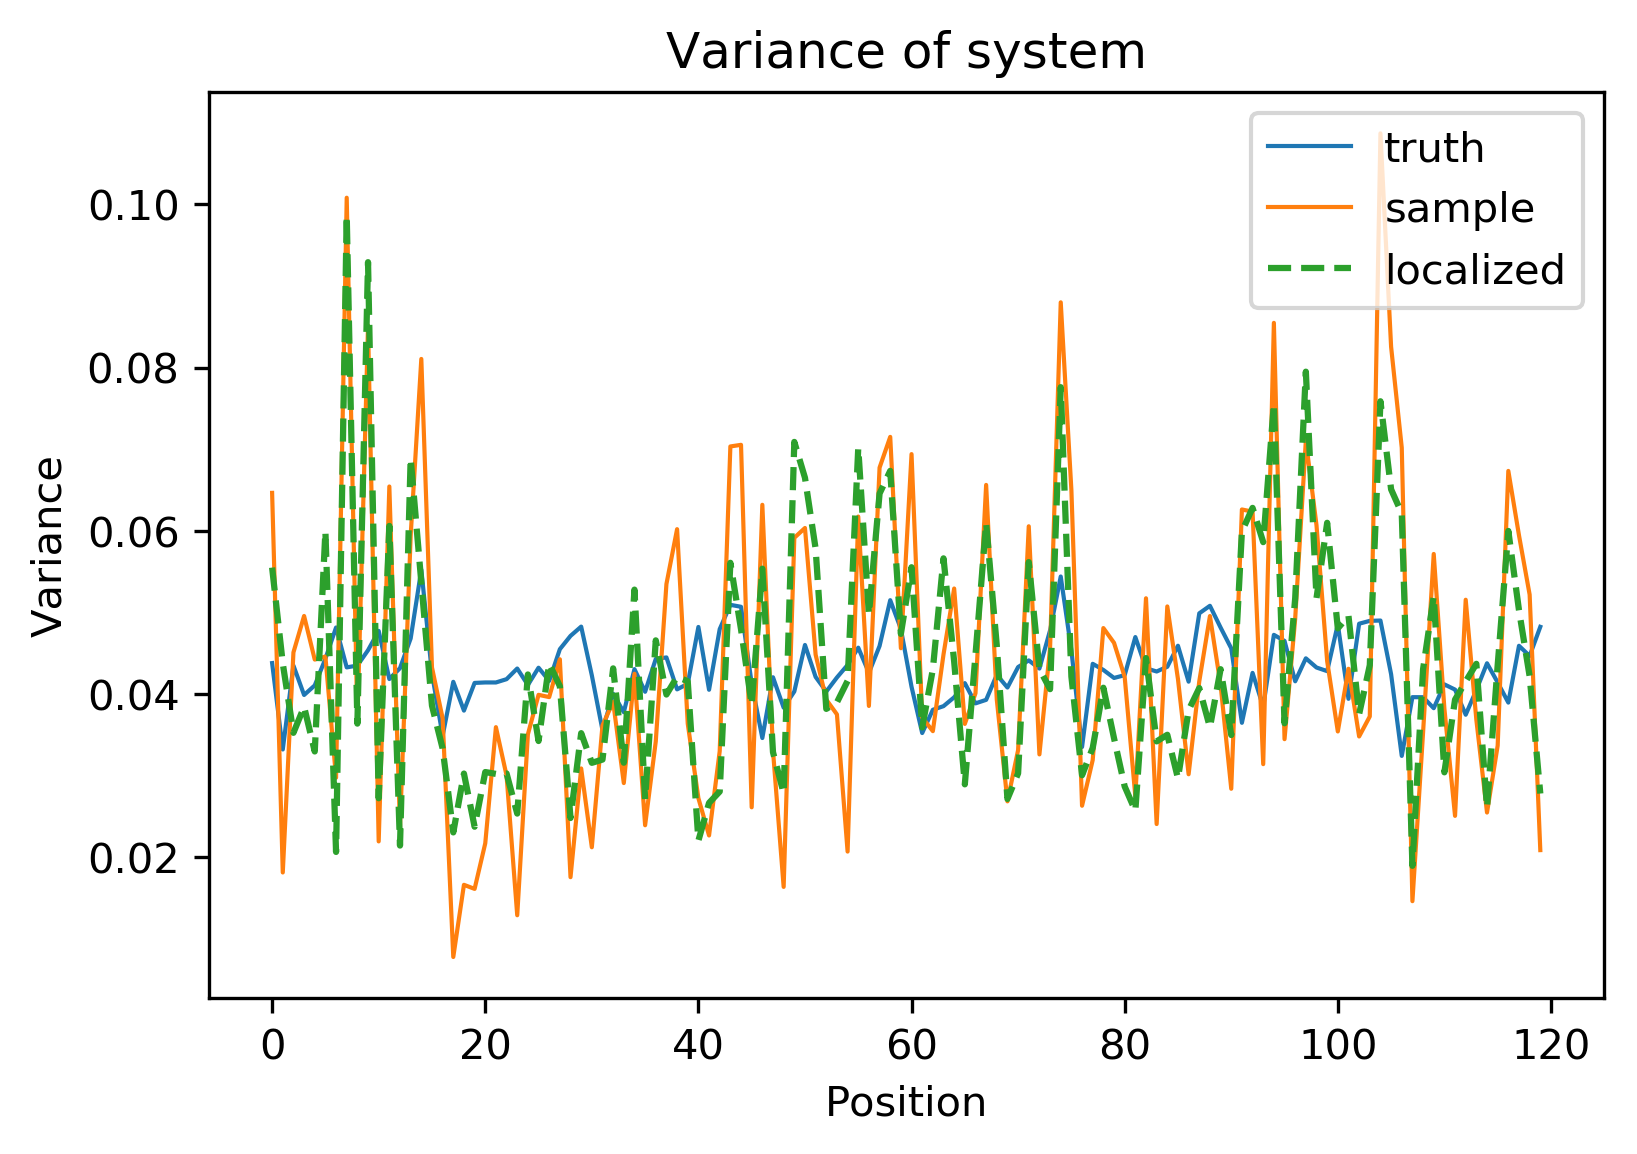

In [345]:
plt.figure(dpi=300)
plt.plot(P_Y.diagonal(), linewidth=1)
plt.plot(P_Y_sample.diagonal(), linewidth=1)
plt.plot(P_Y_sample_loc.diagonal(), linestyle='--')
plt.legend(['truth',
            'sample',
            'localized',
            '1 scale loc'])
plt.xlabel('Position')
plt.ylabel('Variance')
plt.title('Variance of system')

In [346]:
error_1_loc = P_Y_1_loc - P_Y
fro_1_loc = np.round(
    np.linalg.norm(error_1_loc, ord='fro'),
    decimals=3)

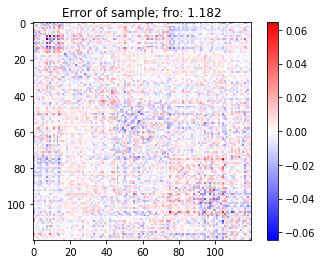

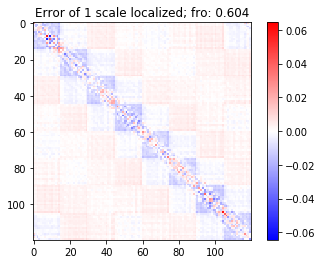

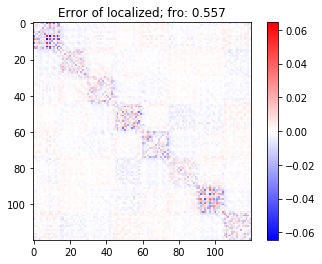

In [347]:
vmax = np.max([
    np.abs(error_sample).max(),
    np.abs(error_localized).max(),
    np.abs(error_1_loc).max()
])
imshow(error_sample,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of sample; fro: {fro_sample}')
imshow(error_1_loc,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of 1 scale localized; fro: {fro_1_loc}')
imshow(error_localized,
       vmax=vmax, vmin=-vmax, cmap='bwr',
       title=f'Error of localized; fro: {fro_localized}')

In [288]:
fro_localized = np.round(
    np.linalg.norm(error_localized, ord=2),
    decimals=3)
fro_1_loc = np.round(
    np.linalg.norm(error_1_loc, ord='fro'),
    decimals=3)
print(f'multi_loc error, frobenius norm: {fro_localized}')
print(f'one scale error, frobenius norm: {fro_1_loc}')

multi_loc error, frobenius norm: 0.253
one scale error, frobenius norm: 0.635
